In [2]:
# Standard Libraries
import glob
import json
import os
import pickle
import random
import re
from collections import defaultdict

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.patches import Patch

# Network Analysis
import networkx as nx

# Progress Bar
from tqdm import tqdm

# Transformers
from transformers import pipeline

# Set font properties for Hebrew (for plots)
rcParams['font.family'] = 'Arial'  # Use a font that supports Hebrew
plt.rcParams['axes.labelweight'] = 'bold'

# HuggingFace Named Entity Recognition (NER) Pipeline
NER = pipeline(
    "token-classification",
    model="avichr/heBERT_NER",
    tokenizer="avichr/heBERT_NER",
)
import textwrap
# OpenAI API Key Configuration
from openai import OpenAI
# Open YAML
import yaml

# Load the API Key
with open(r'/Users/adirserruya/Projects/BigDataMining/MishpatScraper/openai_api_key.yaml') as file:
    api_key = yaml.load(file, Loader=yaml.FullLoader)['api_key']

# Initialize the OpenAI Client
OpenAI.api_key = api_key
client = OpenAI()
client.api_key = api_key

# Check this out for NER of the Free Text: https://huggingface.co/avichr/heBERT_NER


Device set to use mps:0


# Graph Representations for Legal Data Analysis

## 1. Basic Entity-Relationship Graph

### Nodes:
- **Cases**: Represented by `CaseID`.
- **Judges**: Names of judges extracted from `FreeTextWrapped`.
- **Prosecutors**: Entities from the `Prosecutor` field.
- **Defendants**: Entities from the `Defendant` field.

### Edges:
- **"Judged By"**: Connects `CaseID` to Judges.
- **"Prosecutes"**: Connects Prosecutor to `CaseID`.
- **"Defends"**: Connects Defendant to `CaseID`.

### Use Case:
- Find judges commonly involved in politically sensitive cases.
- Discover prosecutors or defendants frequently involved in cases together.

---

## 2. Multi-Mode Graph with Roles

### Nodes:
- **Entities**: Combine `Prosecutors`, `Defendants`, and any named individuals or organizations mentioned in the `FreeTextWrapped`.
- **Cases**: Represented by `CaseID`.
- **Judges**: Names extracted from `FreeTextWrapped`.

### Edges:
- **"Role In"**:
  - From `Entities` to `Cases` with attributes `role = Prosecutor` or `role = Defendant`.
- **"Judged By"**:
  - From `Cases` to `Judges`.

### Attributes:
- **Entities**:
  - `Type`: Whether the entity is an individual, organization, etc.
  - `Political Affiliation` (optional, if inferable).
- **Edges**:
  - `Outcome`: Add case outcome as an attribute to relevant edges.

### Use Case:
- Group entities by their roles in cases.
- Identify political affiliations or networks based on recurring patterns.

---

## 3. Bipartite Graph

### Nodes:
- **Group 1**: Entities (Judges, Prosecutors, Defendants).
- **Group 2**: Cases (`CaseID`).

### Edges:
- Connect each Entity to the `CaseID` where they are involved.

### Use Case:
- Use bipartite projection to identify connections between Entities who have co-appeared in cases (e.g., Prosecutors and Judges commonly associated with the same cases).

---

## 4. Hypergraph Representation

### Hyperedges:
- Represent each case as a **hyperedge** connecting all involved entities (Judges, Prosecutors, Defendants) and linking back to `CaseID`.

### Use Case:
- Analyze the dynamics of groups involved in cases (e.g., frequent co-petitioners).
- Identify political or social blocks in the legal network.

---

## 5. Temporal Graph

### Nodes:
- **Entities**: Judges, Prosecutors, Defendants, and Cases.

### Edges:
- Same as **Basic Entity-Relationship Graph** but with a timestamp (`CaseStartDate`, `CaseVerdictDate`) added as an edge attribute.

### Use Case:
- Study trends over time, such as:
  - Increasing involvement of certain entities.
  - Patterns in case outcomes over specific periods.

---

## 6. Community Detection Graph

### Nodes:
- Same as **Multi-Mode Graph with Roles**.

### Edges:
- Connect entities (e.g., Prosecutors, Defendants, Judges) directly based on:
  - Shared participation in cases.
  - Similar affiliations or roles.

### Use Case:
- Run **community detection algorithms** (e.g., Louvain, Infomap) to:
  - Identify groups of politically connected individuals or organizations.
  - Detect clusters of cases with shared participants.

---

## 7. Content-Driven Graph

### Nodes:
- **Entities**: Named entities (Judges, Prosecutors, Defendants).
- **Cases**: Represented by `CaseID`.

### Edges:
- **"Mentioned In"**:
  - Links entities mentioned in `FreeTextWrapped` to cases.
- **"Semantic Similarity"**:
  - Connect cases with similar content (using embeddings of `FreeTextWrapped`).

### Use Case:
- Use textual similarity to:
  - Cluster cases by topic or political relevance.
  - Highlight recurring legal or political themes.

---

## Graph Representation Example: Multi-Mode Graph

### Nodes:
| Node Type    | Node ID      | Node Attributes                       |
|--------------|--------------|---------------------------------------|
| Case         | 810595       | `Type: Decision`, `IsTechnical: True`|
| Prosecutor   | "M.A.G.N"    | `Type: Organization`                 |
| Defendant    | "M.R.R.G"    | `Type: Organization`                 |
| Judge        | "Judge A"    |                                       |

### Edges:
| Edge Source  | Edge Target   | Edge Type         | Attributes         |
|--------------|---------------|-------------------|--------------------|
| 810595       | "M.A.G.N"     | `Role In`         | `role: Prosecutor` |
| 810595       | "M.R.R.G"     | `Role In`         | `role: Defendant`  |
| 810595       | "Judge A"     | `Judged By`       |                    |

---

## Tools and Techniques

### Libraries:
- **NetworkX**: For building and analyzing the graph.
- **Neo4j**: For large-scale graph storage and querying.
- **Graph-tool**: For efficient large-scale graph computations.

### Algorithms:
- **PageRank**: Identify influential entities.
- **Community Detection**: Discover clusters of connected individuals.
- **Centrality Measures**: Find key nodes (e.g., Judges with high degree centrality).

### Text Analysis:
- Use **NER (Named Entity Recognition)** on `FreeTextWrapped` to extract Judges, additional Prosecutors, Defendants, and other entities.
- Use **topic modeling** (e.g., LDA, embeddings) to identify themes in case content.

### Visualization:
- Use **Gephi** or **Plotly** to create interactive visualizations.
- Highlight political groups or frequently connected entities.


In [4]:
def process_case_data(json_data):
    def unix_to_date(unix):
        """Converts Unix timestamp to human-readable date."""
        return pd.to_datetime(unix, unit='ms')

    # List to store processed case data
    processed_data = []
    failed_to_process = []
    for item in json_data:  # Use 'item' instead of 'case'
        # Basic item information
        try:
            item_info = {}
            item_info['ID'] = item['Id']
            item_info['CaseID'] = item['CaseId']
            item_info['CaseNumber'] = item['CaseNum']
            item_info['Type'] = item['Type']
            item_info['IsTechnical'] = item['Technical']
            item_info['CaseStartDate'] = unix_to_date(int(item['CreatedDate'].split('(')[1].replace(')/', '')))
            item_info['CaseVerdictDate'] = unix_to_date(int(item['VerdictDt'].split('(')[1].replace(')/', '')))
            
            # Prosecutor and Defendant
            item_name_split = item['CaseName'].split('נ.')
            item_info['Prosecutor'] = item_name_split[0].strip() if len(item_name_split) > 1 else None
            item_info['Defendant'] = item_name_split[1].strip() if len(item_name_split) > 1 else None

            # Free text cleaning and wrapping
            if item['free_text']:
                free_text = " ".join(item['free_text'])
                pattern = r"[\n\r\xa0\u200e\u200f\u202a-\u202f\u2000-\u200d\u00a0]"
                cleaned_text = re.sub(pattern, " ", free_text)

                # Wrapping text for display
                wrapper = textwrap.TextWrapper(width=100)
                wrapped_text = "\n".join(wrapper.wrap(cleaned_text))
                item_info['FreeText'] = cleaned_text
                item_info['FreeTextWrapped'] = wrapped_text
            else:
                item_info['FreeText'] = None
                item_info['FreeTextWrapped'] = None

            # Append processed item to list
            processed_data.append(item_info)
        except Exception as e:
            failed_to_process.append(item)
            print(f"Failed to process item: {e}")

    # Create DataFrame
    df = pd.DataFrame(processed_data)
    return df
def extract_locations(text: str) -> list:
    locations = []
    max_text_length = 512  # Maximum text length for NER
    cleaned_text = clean_hebrew_text(text)
    if len(cleaned_text) > max_text_length:
        cleaned_text = cleaned_text[:max_text_length]
    entities = NER(cleaned_text)
    for ent in entities:
        if ent['entity'] == 'B_LOC':
            locations.append(ent['word'])
    return locations
def extract_judges(text: str) -> list:
    # Initialize an empty list to store extracted names
    extracted_judges = []

    # Find all occurrences of "כבוד" and the next 3 words
    pattern = r"(כבוד(?:\s+\S+){1,3})"
    matches = re.findall(pattern, text)

    for match in matches:
        # Split the match into words
        words = match.split()
        # Check if any word contains "'"
        for i, word in enumerate(words):
            if "'" in word:
                # If a word with "'" is found, extract from "כבוד" to one word after this
                extracted_judges.append(" ".join(words[:i + 2]))
                break  # Stop searching for more words in this match

    return extracted_judges

def print_wrapped_text(string_to_wrap):
    """Prints a wrapped text string."""
    print("################################################")
    wrapper = textwrap.TextWrapper(width=100)
    wrapped_text = "\n".join(wrapper.wrap(string_to_wrap))
    print(wrapped_text)
    print("################################################")

shortcuts_mapping = {
    """ע\"בא""": "רצק ש היעבא",
    """ת\"א""": "תונעבות דוחיא",
    """פ\"תא""": "יילילפ יקית דוחיא",
    """\"מא""": "ומיא",
    """ר\"פ""": "וסרפ רוסיא",
    """ח\"פא""": "וח קספ תפיכא",
    """פ\"א""": "תוספורטופא",
    """ל\"ב""": "ימואל חוטיב",
    """ק\"חו""": "הריקח תודעו קוח יפל סנק לוטיב",
    """מ\"קב""": "ילהנמ סנק לוטיב",
    """ת\"ת""": "לעופל האצוהב העיבת עוציב",
    """מ\"דיב""": "דחוימ יד תיב",
    """ש\"מדב""": "יטפושל יתעמשמ יד תיב",
    """ק\"עב""": "לוקיע רושיאל השקב",
    """מ\"פב""": "בכרב שומיש רוסיא/תילהנמ הליספ לוטיבל השקב",
    """פ\"הע""": "הערפה לשב לטוהש שנוע לוטיבל השקב",
    """\"הב""": "יאושינ תרתהל השקב",
    """ת\"פב""": "יכילהה ות דע הליספל השקב",
    """ע\"שב""": "הבורעב רורחשל השקב",
    """ת\"תב""": "וכת ולשתל השקב",
    """נ\"בב""": "היינב תושקב",
    """א\"עב""": "תורחא הייריע תושקב",
    """ש\"רב""": "יושיר תושקב",
    """ע\"רב""": "רוערע תושר תשקב",
    """ד\"בש""": "יחרזא ילהב יד לעב טפוש תשקב",
    """א\"נש""": "שאנ טפוש תשקב",
    """ר\"מג""": "תינלשר הגיהנב תוומ תמירג",
    """ר\"מד""": "שר תוכמסב ריהמ ויד",
    """ש\"מד""": "טפוש תוכמסב ריהמ ויד",
    """א\"נד""": "יחרזא סונ ויד",
    """\"גנד""": "\"גב סונ ויד",
    """מ\"נד""": "ילהנמ סונ ויד",
    """פ\"נד""": "ילילפ סונ ויד",
    """ט\"ד""": "ינוגרא לופיט ימד",
    """ת\"סה""": "רתס תנזאה",
    """ע\"מה""": "רצעמ תכראה",
    """כ\"ה""": "ייקסע ילבגה",
    """ת\"ה""": "סופת תרזחה",
    """ט\"ה""": "הנגה וצו תמייאמ הדרטה",
    """נ\"ה""": "יאושינ רתיה",
    """פ\"ה""": "החיתפ תצרמה",
    """ב\"פה""": "תוררוב החיתפ תצרמה",
    """פ\"דה""": "ילילפ ויד וקמ תרבעה",
    """ד\"ה""": "ויד וקמ תרבעה",
    """ט\"ת""": "רטש עוציבל תודגנתה",
    """\"הת""": "יאושינ תרתה",
    """ע\"ו""": "ררע תדעו",
    """א\"ח""": "דיחא הזוח",
    """ר\"בח""": "יתכלממ תואירב חוטיב קוח",
    """מ\"עח""": "טפשמ תרירב יינוריע רזע יקוח",
    """ק\"עח""": "סנק תרירב יינוריע רזע יקוח",
    """ד\"ח""": "יד רוקיח",
    """נ\"ח""": "היינח",
    """מ\"סח""": "תוומ תוביס תריקח",
    """ס\"י""": "וסכס בושיי",
    """צ\"כ""": "יתד יד תיב תויצ תייפכ",
    """מ\"קמ""": "ילהנמ סנק רסאמ",
    """י\"מ""": "ימי רצעמ",
    """ב\"ימ""": "רדעהב ימי רצעמ",
    """מ\"מ""": "ילהנמ רצעמ",
    """ת\"מ""": "יכילהה ות דע רצעמ",
    """ח\"מ""": "רזוח טפשמ",
    """ד\"ענ""": "ייובש וא ירדענ לש שוכר לוהינ",
    """ע\"ס""": "הדובע וסכס",
    """ק\"ס""": "יצוביק וסכס",
    """כ\"קס""": "יללכ יצוביק וסכס",
    """ל\"פ""": "תוח\"וד ניאו יכרד תונואת ניאש תוריבע",
    """א\"מע""": "ירחא יימוקמ יניינע",
    """א\"ע""": "יחרזא רוערע",
    """ז\"בע""": "טפשמ תיב ויזב רוערע",
    """ב\"ע""": "תוריחב רוערע",
    """ל\"בע""": "ימואל חוטיב רוערע",
    """ר\"חע""": "שוכר טוליח רוערע",
    """נ\"ע""": "יכנה קוח יפל רוערע",
    """מ\"רע""": "תעמשמ תוימוקמה תויושרה קוח יפל רוערע",
    """ח\"מע""": "הכרעמב ופסנש ילייח קוח יפל רוערע",
    """ע\"לע""": "ידה יכרוע תכשל רוערע",
    """נ\"מע""": "ילהנמ רוערע",
    """מ\"ע""": "יסמ רוערע",
    """מ\"שע""": "הנידמ ידבוע יתעמשמ רוערע",
    """ש\"מע""": "החפשמ רוערע",
    """א\"נע""": "יחרזא רעונ רוערע",
    """פ\"נע""": "ילילפ רעונ רוערע",
    """ש\"מנע""": "תינוטלש הרשמ יאשונ רוערע",
    """ק\"סע""": "יצוביק וסכס רוערע",
    """ע\"ע""": "הדובע רוערע",
    """י\"בע""": "תעמשמל יד תיב לע רוערע",
    """מ\"שמע""": "הנידמ ידבוע לש יתעמשמ יד תיב לע רוערע",
    """מ\"רמע""": "תוימוקמ תויושר לש יתעמשמ יד תיב לע רוערע",
    """פ\"רמע""": "ילילפ שר תטלחה לע רוערע",
    """ר\"מע""": "שר תטלחה לע רוערע",
    """פ\"מע""": "תוגלפמה שר תטלחה לע רוערע",
    """ר\"שע""": "החוורהו הדובעה רש תטלחה לע רוערע",
    """ו\"ע""": "הדעו לע רוערע",
    """ח\"לע""": "קוח יפ לע רוערע",
    """נ\"קע""": "שאנ י\"ע תילילפ הנלבוק לע רוערע",
    """פ\"קע""": "לבוקה י\"ע תילילפ הנלבוק לע רוערע",
    """מ\"עע""": "תילהנמ הנעבות/הריתע רוערע",
    """א\"תעע""": "ריסא תריתע רוערע",
    """פ\"ע""": "ילילפ רוערע פ\"ע",
    """א\"פע""": "רחא ילילפ רוערע",
    """ג\"פע""": "יד רזג ילילפ רוערע",
    """ר\"פע""": "חצר ילילפ רוערע",
    """ת\"פע""": "הרובעת ילילפ רוערע",
    """פ\"ספע""": "ילילפ טפוש תולספ רוערע",
    """ס\"פע""": "טפוש תולספ רוערע",
    """א\"שע""": "יחרזא הנוש רוערע",
    """ש\"ע""": "הנוש רוערע",
    """ת\"שע""": "הקוסעתה תוריש רוערע",
    """ח\"ע""": "רחא ררע",
    """פ\"בע""": "תירטאיכיספ הקידב ררע",
    """פ\"אע""": "וסרפ רוסיא יינעב ררע",
    """ע\"חע""": "תויוברע טוליח יינעב ררע",
    """ר\"עע""": "העיבתה תויארב ויע יינעב ררע",
    """ע\"פע""": "יד רוע ע השיגפ יינעב ררע",
    """ג\"הע""": "ימ ינירבע ינפמ רוביצה תנגה ררע",
    """י\"מע""": "י\"מ ררע",
    """ת\"מע""": "ת\"מ ררע",
    """ב\"כע""": "עוציב בוכיע ררע",
    """מ\"קע""": "ילהנמ סנק הבוג לע ררע",
    """ק\"חע""": "ימה קוח יפ לע ררע",
    """מ\"פע""": "תילהנמ הליספ לע ררע",
    """\"פע""": "וישר תליספ לע ררע",
    """\"גב""": "\"גבל הריתע",
    """ר\"גע""": "היאר יוליגל הריתע",
    """מ\"תע""": "תילהנמ הריתע",
    """א\"תע""": "יריסא תוריתע",
    """ח\"קפ""": "ירחא יקוחו חוקיפ",
    """ק\"רפ""": "יקוריפ",
    """ה\"פ""": "יללכ יתרהצה יד קספ",
    """ר\"שפ""": "לגר תטישפ",
    """א\"צ""": "רחא וצ",
    """ה\"צ""": "(212) העשרה אלל הסירה וצ",
    """ח\"צ""": "הסינכ וצ / שופיח וצ",
    """כ\"מ""": "יללכ רצעמ וצ",
    """ו\"צ""": "( יעובק) העינמ וצ/השע וצ",
    """פ\"ק""": "תילילפ הנלבוק",
    """ג\"ק""": "למג תפוק",
    """ס\"ער""": "יקסע יושיר",
    """א\"ער""": "יחרזא רוערע תושר",
    """מ\"ער""": "ילהנמ רוערע תושר",
    """ש\"מר""": "החפשמ רוערע תושר",
    """פ\"צר""": "לעופל האצוה לע רוערע תושר",
    """צ\"ער""": "פ\"לצוה שאר תטלחה לע רוערע תושר",
    """ו\"ער""": "הדעו לע רוערע תושר",
    """ב\"ער""": "תוררוב קספ לע רוערע תושר",
    """א\"תער""": "ריסא תריתע רוערע תושר",
    """פ\"ער""": "ילילפ רוערע תושר",
    """ש\"ער""": "הנוש רוערע תושר",
    """ק\"תר""": "תונטק תועיבת רוערע תושר",
    """ש\"ש""": "ש יוניש",
    """ש""": "תוריכש ש",
    """ע\"ש""": "שר תוכמסב הדובע רכש",
    """ד\"ת""": "יכרד תנואת",
    """ב\"נ""": "וג יעגפנ אלל יכדרד תנואת",
    """ק\"מת""": "רצוקמ יד רדסב תנכוממ",
    """ר\"מת""": "ליגר יד רדסב תנכוממ",
    """ג\"נת""": "תרזגנ",
    """ק\"ת""": "הנטק",
    """ב\"ת""": "תוררוב",
    """א\"בס""": "תוינוגרא",
    """ז\"זג""": "תזזגה קוח",
    """ש\"ח""": "ינוש יקוח חכמ",
    """א\"גת""": "ארבג",
    """ח\"ת""": "אצפח",
    """ז\"נת""": "תוקקזנ",
    """א\"עת""": "ידבוע וגראל דבוע יב",
    """צ\"ת""": "תיגוציי",
    """מ\"ת""": "תילהנמ",
    """מ\"את""": "ריהמ יד רדסב",
    """ח\"את""": "דחוימ יד רדסב",
    """ק\"את""": "רצוקמ יד רדסב",
    """א\"ת""": "ליגר יד רדסב",
    """ג\"הת""": "הרגסה",
    """ס\"הת""": "כסה",
    """ל\"ע""": "וילע",
    """א\"לת""": "רותיאל",
    """ב\"לת""": "צ\"גב רותיאל",
    """פ\"לת""": "ילילפ רותיאל",
    """ש\"מת""": "החפשמ",
    """ע\"ת""": "תונובזע",
    """פ\"ת""": "ילילפ",
    """ח\"פת""": "ירומח יעשפ",
    """ג\"ת""": "ליג",
    """ח\"תת""": "הרובחת",
    """ע\"תת""": "הרובעת",
    """ח\"ות""": "תויזוחמ תודעו היינבו ונכת",
    """ב\"ות""": "תוימוקמ תודעו היינבו ונכת",
    """ש\"מה""": "טפשיהל דעומ",
    """ז\"עה""": "ירז ידבוע",
    """מ\"ש""": "ומינימ רכש",
    """מ\"עש""": "החונמו הדובע תועש"
}
shortcuts_mapping_reversed = {key[::-1]:value[::-1] for key, value in shortcuts_mapping.items()}
shortcuts_mapping_reversed["""בג"ץ"""] = "בגץ"
shortcuts_mapping_reversed["""רעב"ס"""] = "רשות ערעור בתי סוהר"
shortcuts_mapping_reversed["""עע"ם"""] = """"עע"ם"""
shortcuts_mapping_reversed["""עבע"ח"""] = """עבע"ח"""
shortcuts_mapping_reversed["""בר"ם"""] = """בית המשפט לרבנים"""
shortcuts_mapping_reversed["""עע"כ"""] = """ערכאות כללית"""
shortcuts_mapping_reversed["""עמ"ם"""] = """עמ"ם"""
shortcuts_mapping_reversed["""בש"א"""] = """בית המשפט לשיפוט אדמיניסטרטיבי"""
shortcuts_mapping_reversed["""בש"פ"""] = """בית המשפט לשיפוט פלילי"""
shortcuts_mapping_reversed["""עפ"ה"""] = """עפ"ה"""
shortcuts_mapping_reversed["""ער"א"""] = """ער"א"""
shortcuts_mapping_reversed["""עמ"ז"""] = """עמ"ז"""
shortcuts_mapping_reversed["""בר"מ"""] = """בית המשפט לרכוש מוגנ"""
shortcuts_mapping_reversed["""בע"מ"""] = """בית המשפט לעבודה"""
shortcuts_mapping_reversed["""עמ"מ"""] = """עמ"מ"""
shortcuts_mapping_reversed["""דנג"ץ"""] = """דנגץ"""
shortcuts_mapping_reversed["""עה"ס"""] = """עה"ס"""
shortcuts_mapping_reversed["""בעת"מ"""] = """בית המשפט לתביעות קטנות"""
shortcuts_mapping_reversed["""ער"פ"""] = """ערפ"""
shortcuts_mapping_reversed["""בש"מ"""] = """בית המשפט לשיפוט מוסדי"""
shortcuts_mapping_reversed["""בע"ם"""] = """בית המשפט לערעורים"""
shortcuts_mapping_reversed["""בשג"ץ"""] = """בית המשפט לשפוט גירושין"""
shortcuts_mapping_reversed["""ערג"ץ"""] = """ערגץ"""


def classify_topic(free_text: str, shortcuts_mapping: dict) -> str:

    if not isinstance(free_text, str):
        return "Unknown"  # Handle cases where FreeText is missing or not a string
    non_existent = []
    # Extract the first 20 words
    first_20_words = set(free_text.split()[:30])  # Use a set for fast lookup
    # Search for any of the shortcuts in the first 20 words
    for shortcut, topic in shortcuts_mapping.items():
        if shortcut in first_20_words:
            return topic  # Return the corresponding topic if an exact match for the shortcut is found
    print(list(first_20_words)[:20])
    return "Unknown"  # Return 'Unknown' if no match is found

def extract_verdict(text:str): 
    if not isinstance(text, str):
        return "Unknown"  # Handle cases where FreeText is missing or not a string
    if 'העתירה נדחית' in text or 'לדחות את העתירה' in text or 'העתירה  נדחית' in text or 'נדחתה' in text[-1000:] or \
        'נדחה' in text[-1000:] or 'דחיית' in text[-1000:] or 'נדחית' in text[-1000:] or 'לדחות' in text[-1000:] or 'להדחות' in text or \
        'נדחות' in text[-1000:] or 'נדחית' in text[-1000:] or 'איננו עומד' in text[-1000:] or 'לא עומד' in text[-1000:] or 'לא יוכל' in text[-1000:] or \
        'להידחות' in text[-1000:] or 'להיעתר' in text[-2000:]:
        return "Denied"
    elif 'העתירה נמחקת' in text or 'למחוק את העתירה' in text or 'העתירה  נמחקת' in text or 'נמחקה' in text[-1000:] or \
        'נמחק' in text[-1000:] or 'מחיקת' in text[-1000:] or 'להימחק' in text[-1000:] or 'מוצתה' in text[-1000:]:
        return "Delted"
    elif 'התקבלה' in text or 'העתירה מקובלת' in text or 'העתירה  מקובלת' in text or 'העתירה מקובלת' in text or 'ניתן  היום' in text:
        return "Accepted"
    else:
        return "Unknown"
    

def clean_hebrew_text(text: str) -> str:
    # Remove URLs
    text = re.sub(r"http[s]?://\S+", "", text)
    
    # Remove mentions (@username) and hashtags (#tag)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Remove punctuations (except for basic sentence structure)
    text = re.sub(r"[\"!#$%&()*+\-./:;<=>?@[\\\]^_`{|}~]", "", text)
    
    # Remove emojis and special symbols
    text = re.sub(r"[^\w\sא-ת]", "", text, flags=re.UNICODE)
    
    # Remove multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Normalize text (optional, for consistent formatting)
    # e.g., removing diacritics (Niqqud) or special formatting
    text = re.sub(r"[ֲִֵֶַָֻּּׁ]", "", text)  # Removes Hebrew diacritics if present

    return text

def extract_parties_hebrew(text: str) -> dict:
    parties = {"Prosecutor": None, "Prosecuted": []}

    # Find "נ ג ד" and extract subtext around it
    neged_pattern = r"(?:\S+\s+){0,10}נ\s+ג\s+ד(?:\s+\S+){0,50}"
    neged_match = re.search(neged_pattern, text)
    
    if not neged_match:
        # Try again with "נגד" without spaces
        neged_pattern = r"(?:\S+\s+){0,10}נגד(?:\s+\S+){0,50}"
        neged_match = re.search(neged_pattern, text)
        if not neged_match:
            return parties  # If neither "נ ג ד" nor "נגד" is found, return empty parties

    subtext = neged_match.group(0)

    # Extract prosecutor (similar to the current implementation)
    prosecutor_pattern = r"([^:]+):\s*([^:]+)\s+נ\s+ג\s+ד"
    prosecutor_match = re.search(prosecutor_pattern, subtext)
    if prosecutor_match:
        parties["Prosecutor"] = prosecutor_match.group(2).strip()

    # Handle prosecuted extraction
    prosecuted_pattern = r"(משיבים|משיבה|משיב)"
    prosecuted_match = re.search(prosecuted_pattern, subtext)
    
    if prosecuted_match:
        # Identify type of prosecuted (e.g., משיבים, משיבה, משיב)
        prosecuted_type = prosecuted_match.group(1)
        
        if prosecuted_type == "משיבים":
            # Use numbered pattern for "משיבים"
            numbered_pattern = r"(\d{1,2}\.)\s*([\u0590-\u05FF\s\-.,]+)"
            numbered_matches = re.findall(numbered_pattern, subtext)
            
            if numbered_matches:
                processed_numbers = set()
                for number, entity in numbered_matches:
                    if number not in processed_numbers:
                        # Extract entity only until the first comma or period
                        clean_entity = re.split(r"[,.\n]", entity, maxsplit=1)[0].strip()
                        parties["Prosecuted"].append(clean_entity)
                        processed_numbers.add(number)
            # For last match remove last word
            if len(parties["Prosecuted"]) > 1:
                parties["Prosecuted"][-1] = parties["Prosecuted"][-1].rsplit(' ', 1)[0]


        elif prosecuted_type in ["משיבה", "משיב"]:
            # Extract two words after "משיבה" or "משיב"
            prosecuted_after = subtext[subtext.index(prosecuted_type):]
            words_after = prosecuted_after.split()
            if len(words_after) > 2:
                candidate = " ".join(words_after[1:3]).strip()
                # Check for "פלוני"
                if "פלוני" in candidate:
                    parties["Prosecuted"] = ["פלוני"]
                else:
                    parties["Prosecuted"] = [candidate]
    
    return parties

def unix_to_date(unix):
    return pd.to_datetime(unix, unit='ms')

def extract_orgs_using_ner(NER, text: str) -> list:
    max_text_length = 512  # Maximum text length for NER
    cleaned_text = clean_hebrew_text(text)
    if len(cleaned_text) > max_text_length:
        cleaned_text = cleaned_text[:max_text_length]
    entities = NER(cleaned_text)
    orgs = [ent['word'] for ent in entities if ent['entity'] == 'B_ORG']
    return orgs

def classify_text(client,text: str) -> str:
    prompt = (
            "Given the following Hebrew text and Prosecutors (Petitioners), classify it into one of the following categories: "
            "Right Wing, Left Wing, or Neutral. "
            "Respond only with the category name and nothing else.\n\n"
            f"Text: {text}"
        )
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a classifier that labels Hebrew text as Right Wing, Left Wing, or Neutral."},
                {"role": "user", "content": prompt},
            ],
        )
        return response
    except Exception as e:
        print(f"Error querying GPT: {e}")
        
def calculate_color(proportions):
    """Calculate the RGB color blend based on case proportions."""
    total = sum(proportions.values())
    if total == 0:
        return (0.5, 0.5, 0.5)  # Default gray for no data
    red = proportions["Right"] / total
    blue = proportions["Left"] / total
    green = proportions["Neutral"] / total
    return (red, green, blue)

def inverse_chars(text: str) -> str:
    return text[::-1]

def classify_legal_text(client,text: str) -> str:
    prompt = f"""
        You are a helpful and super intelligent legal assistant.
        Your job is to classify the topic of the following legal text (In hebrew).
        Text: {text}
        """

    # Call the OpenAI Chat API (using ChatCompletion API)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful legal assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200,
        temperature=0.2,  # Lower temperature for focused responses
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    # Extract the model's classification result
    response = response.choices[0].message.content
    return response

def filter_cases(df, **filters):
    filtered_df = df.copy()  # Avoid modifying the original DataFrame

    for column, condition in filters.items():
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame")
        
        # Apply filtering based on the type of condition
        if isinstance(condition, (list, set, tuple)):  # If multiple values are provided
            filtered_df = filtered_df[filtered_df[column].isin(condition)]
        elif callable(condition):  # If a callable (e.g., lambda function) is provided
            filtered_df = filtered_df[filtered_df[column].apply(condition)]
        else:  # Single value condition
            filtered_df = filtered_df[filtered_df[column] == condition]
    
    return filtered_df


# # Example 1: Filter by single value
# result1 = filter_cases(df, Type="Criminal")
# print(result1)

# # Example 2: Filter by multiple values
# result2 = filter_cases(df, Topic=["Fraud", "Contracts"])
# print(result2)

# # Example 3: Filter using a lambda function
# result3 = filter_cases(df, CaseID=lambda x: x.startswith("A"))
# print(result3)

# # Example 4: Combine multiple filters
# result4 = filter_cases(df, Type="Civil", Judge="Judge C")
# print(result4)

# Data Extraction Experimentation

In [6]:
# Extract all paths of the json files using glob
json_files = glob.glob(r"/Users/adirserruya/Projects/BigDataMining/MishpatScraper/data-mishpat/*.json")
# Sample json
path = r"/Users/adirserruya/Projects/BigDataMining/MishpatScraper/data-mishpat/response_2020-07-25.json"
with open(path) as f:
    data = json.load(f)
    
cases = len(data)
print(f"Number of cases: {cases}")

prosecutor = data[0]['CaseName'].split('נ.')[0].strip()
print(f"Prosecutor: {prosecutor}")

defendent = data[0]['CaseName'].split('נ.')[1].strip()
print(f"Defendent: {defendent}")

id = data[0]['Id']
case_id = data[0]['CaseId']
case_start_date = data[0]['CreatedDate'].split('(')[1].replace(')/', '')
case_verdict_date = data[0]['VerdictDt'].split('(')[1].replace(')/', '')



print(f"ID: {id}")
print(f"Case ID: {case_id}")
print(f"Case Start Date: {unix_to_date(int(case_start_date))}")
print(f"Case Verdict Date: {unix_to_date(int(case_verdict_date))}")
print(f"Type of case: {data[0]['Type']}")
print(f"Case Number: {data[0]['CaseNum']}")
print(f"IsTechnical: {data[0]['Technical']}")
free_text = data[0]['free_text']
# Define a pattern for unwanted characters
pattern = r"[\n\r\xa0\u200e\u200f\u202a-\u202f\u2000-\u200d\u00a0]"
new_free = re.sub(pattern, "", " ".join(free_text))
# Print Wrapped Text
wrapper = textwrap.TextWrapper(width=100)
word_list = wrapper.wrap(text=new_free)
wrapped_text = ''
for element in word_list:
    wrapped_text += element + '\n'
print(wrapped_text)
print(new_free)
print(type(new_free))
data[0]
# free_text = data[1]['free_text']


Number of cases: 248
Prosecutor: "סל" שירותי סיעוד
Defendent: מדינת ישראל
ID: 738466
Case ID: 229730
Case Start Date: 2022-07-20 07:17:12.810000
Case Verdict Date: 2020-07-26 21:00:00
Type of case: תקצירים
Case Number: 1633
IsTechnical: False
בית המשפטהעליון הודעה לתקשורת - פסק דין בבג"ץ 1633/20 ובבג"ץ2070/20 בעניין הוצאת תעודת מחלה גורפת
לעובדים שכירים שנמצאים בבידוד בשל חששלהידבקות בנגיף הקורונה בית המשפט העליון (השופט א' שטייןבהסכמת
הנשיאה א' חיות והשופט ע' פוגלמן) קיבל היום שתי עתירות שהגישו, בין היתר,מספר ארגוני מעסיקים וקבע כי
חוק דמי מחלה אינו מסמיך את ראש שירותי בריאות הציבורבמשרד הבריאות להנפיק תעודת מחלה גורפת לכל העובדים
השכירים השוהים בבידוד מחששלהידבקות בנגיף הקורונה. על כן נקבע כי תעודת המחלה הגורפת בטלה. בית המשפט
הגיע למסקנה זו לאחרשניתח את לשון חוק דמי מחלה ותכליותיו וקבע כי חשש למחלה או להידבקות בנגיףהקורונה
אינו בגדר "מחלה" ששוללת מהעובד את הכושר לבצע את עבודתו, כנדרשבחוק. עם זאת ועל מנת למנוע פגיעה
בעובדים ולאפשר היערכות מתאימה, נקבע כי ביטולהשל תעודת המחלה הגורפת ל

{'Id': 738466,
 'CaseId': 229730,
 'VerdictDt': '/Date(1595797200000)/',
 'CreatedDate': '/Date(1658301432810)/',
 'VerdictsDtString': '27/07/2020',
 'CaseNum': 1633,
 'CaseDesc': 'בג"ץ 1633-20',
 'Pages': 1,
 'Path': 'HebrewVerdicts\\20\\330\\016\\t16',
 'PathForWeb': 'HebrewVerdicts/20/330/016/t16',
 'CaseName': '"סל" שירותי סיעוד נ. מדינת ישראל',
 'FileName': '20016330.T16.SUM',
 'DocName': '20016330.T16.SUM.docx',
 'Content': None,
 'Year': 2020,
 'TypeCode': 6,
 'Type': 'תקצירים',
 'CaseDt': None,
 'MadorDesc': None,
 'SeqNum': 0,
 'Technical': False,
 'FolderPath': 'HebrewVerdicts\\20\\330\\016\\t16',
 'PageVolume': None,
 'DescVolume': None,
 'CodeVolume': 0,
 'liked': False,
 'InyanId': 8,
 'QuoteYear': 0,
 'CodeQuote': None,
 'CodeTitle': None,
 'VerdictDesc': None,
 'DocNumber': None,
 'Month': None,
 'free_text': ['בית המשפט\r\nהעליון',
  'הודעה לתקשורת \xa0- פסק דין בבג"ץ 1633/20 ובבג"ץ\r\n2070/20 בעניין הוצאת תעודת מחלה גורפת לעובדים שכירים שנמצאים בבידוד בשל חשש\r\nלהידבק

# Processing all of my data

In [5]:
dfs = []
for path in tqdm(json_files):
    with open(path, 'r') as f:
        data = json.load(f)

    dfs.append(process_case_data(data))

# Concatenate all DataFrames
all_cases_df = pd.concat(dfs, ignore_index=True)
cases_with_free_text = all_cases_df[all_cases_df['FreeText'].notnull()].copy()
cases_with_free_text.reset_index(drop=True, inplace=True)
# Save
all_cases_df.to_csv('all_cases.csv', index=False)
cases_with_free_text.to_csv('cases_with_free_text.csv', index=False)

NameError: name 'json_files' is not defined

# Reading the data

In [7]:
# Read all cases df
all_cases_df = pd.read_csv('all_cases.csv')
cases_with_free_text = pd.read_csv('cases_with_free_text.csv')
cases_with_free_text['CaseStartDate'] = pd.to_datetime(cases_with_free_text['CaseStartDate'])
cases_with_free_text['CaseVerdictDate'] = pd.to_datetime(cases_with_free_text['CaseVerdictDate'])
cases_with_free_text.sort_values(by='CaseStartDate', ascending=False, inplace=True)

In [ ]:
## IDEATION
# Nodes can be cases, links can be between cases with the same prosecutor/defendant/judge
# Nodes can be judges, links can be between judges who have worked on the same case
## Multi Nodes Scenario - Triangle Nodes - Cases, Squares - Judges, Circles - Prosecutors/Defendants
  # Links between Triangle and Square - Judge worked on a case
    # Links between Triangle and Circle - Prosecutor/Defendant in a case
    # Links Between Trianges - Cases with the same prosecutor/defendant/judge

# Extracting Judges and Parties

In [8]:
cases_with_free_text['PartiesExtracted'] = cases_with_free_text['FreeTextWrapped'].apply(extract_parties_hebrew)
# cases_with_free_text['Prosecutor'] = cases_with_free_text['PartiesExtracted'].apply(lambda x: x['Prosecutor'])
cases_with_free_text['Prosecuted'] = cases_with_free_text['PartiesExtracted'].apply(lambda x: x['Prosecuted'])
cases_with_free_text.drop(columns=['PartiesExtracted'], inplace=True)
cases_with_free_text['Judge'] = cases_with_free_text['FreeTextWrapped'].apply(extract_judges)
# Cases with free text where Judge is not an empty list
cases_with_judges = cases_with_free_text[cases_with_free_text['Judge'].apply(len) > 0].copy()

# Graph Analysis

In [9]:
# Initialize a graph
G = nx.Graph()

df = cases_with_judges.copy()
df.drop(
    columns=[
        "ID",
        "IsTechnical",
        "CaseStartDate",
        "CaseVerdictDate",
        "FreeText",
        "FreeTextWrapped",
        "Prosecuted",
    ],
    inplace=True,
)

# Add nodes to the graph
for idx, row in df.iterrows():
    G.add_node(
        row["CaseID"],
        label=row["CaseNumber"],
        type="Case",
        prosecutor=row["Prosecutor"],
        defendant=row["Defendant"],
    )

# Convert the Judge column to a string to allow for easy comparison
df["JudgeStr"] = df["Judge"].apply(lambda x: ",".join(sorted(x)))

# Use vectorized operations to find identical Judge lists
print("Building graph...")
connections = (
    df[["CaseID", "JudgeStr"]]
    .merge(df[["CaseID", "JudgeStr"]], on="JudgeStr", suffixes=("_1", "_2"))
    .query("CaseID_1 < CaseID_2")
)

# Ensure consistent ordering of CaseID_1 and CaseID_2
connections['sorted_ids'] = connections.apply(
    lambda row: tuple(sorted([row['CaseID_1'], row['CaseID_2']])), axis=1
)

# Drop duplicates based on the sorted IDs
connections = connections.drop_duplicates(subset='sorted_ids').drop(columns=['sorted_ids'])


# Add edges to the graph
for _, row in tqdm(connections.iterrows(), total=len(connections), desc="Adding edges"):
    G.add_edge(row["CaseID_1"], row["CaseID_2"])


# Save the graph to a file
with open('cases_graph_optimized.gpickle', 'wb') as file:
    pickle.dump(G, file)

print("Graph saved successfully.")




Building graph...


Adding edges: 100%|██████████| 5760453/5760453 [01:40<00:00, 57298.18it/s]


Graph saved successfully.


In [10]:
# Ensure consistent ordering of CaseID_1 and CaseID_2
connections['sorted_ids'] = connections.apply(
    lambda row: tuple(sorted([row['CaseID_1'], row['CaseID_2']])), axis=1
)

# Drop duplicates based on the sorted IDs
connections_deduplicated = connections.drop_duplicates(subset='sorted_ids').drop(columns=['sorted_ids'])

print(f"Original connections: {len(connections)}")
print(f"Deduplicated connections: {len(connections_deduplicated)}")


Original connections: 5760453
Deduplicated connections: 5760453


/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/2799180073.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', len(top_judges))


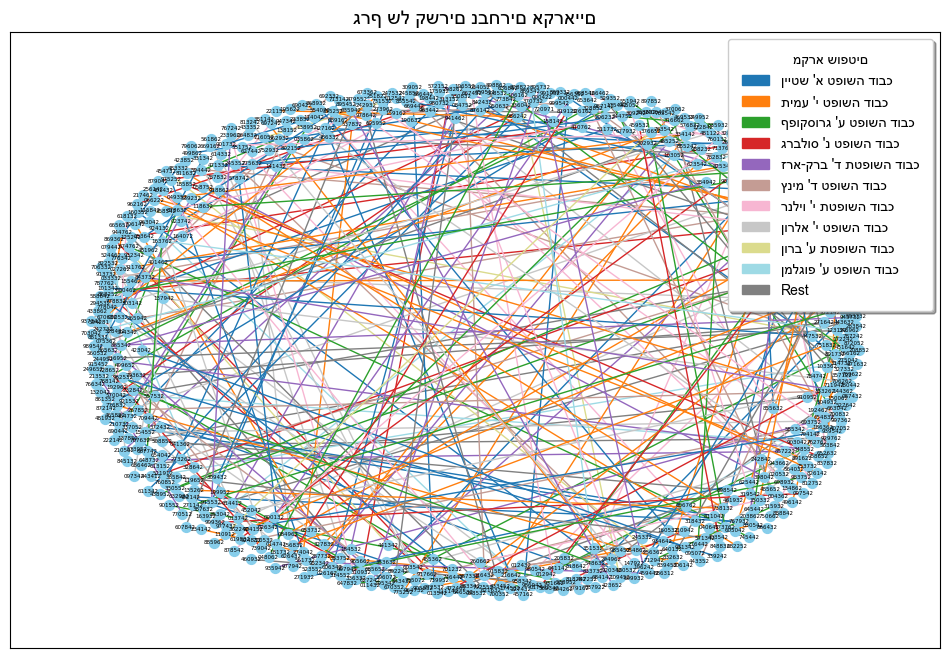

In [11]:

# Sample 1000 connections from the connections DataFrame
sampled_connections = connections.sample(300)

# Extract unique nodes from the sampled connections
sampled_nodes = set(sampled_connections['CaseID_1']).union(sampled_connections['CaseID_2'])

# Create a subgraph with the sampled nodes and edges
subgraph = nx.Graph()

# Unique judges
judges = df['Judge'].explode().unique()

# Colors for top 10 judges and grey for the rest
top_judges = df['Judge'].explode().value_counts().index[:10]
# Generate random colors for judges
color_palette = plt.cm.get_cmap('tab20', len(top_judges))
judge_colors = {judge: color_palette(i) for i, judge in enumerate(top_judges)}
judge_colors.update({judge: "grey" for judge in judges if judge not in top_judges})

# Save the mapping
with open('judge_colors_mapping.json', 'w', encoding="utf-8") as f:
    json.dump(judge_colors, f, ensure_ascii=False)

# Add edges from the sampled connections
for _, row in sampled_connections.iterrows():
    node1 = row['CaseID_1']
    node2 = row['CaseID_2']
    color = judge_colors[row['JudgeStr']] if row['JudgeStr'] in top_judges else "grey"
    if node1 != node2:
        subgraph.add_edge(node1, node2, judge=row['JudgeStr'], color=color)

# Visualization of the subgraph
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(subgraph, k=1000, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color="skyblue")
nx.draw_networkx_edges(
    subgraph,
    pos,
    edge_color=[subgraph[u][v]['color'] for u, v in subgraph.edges]
)

# Draw labels, with RTL support
labels = {node: str(node)[::-1] for node in subgraph.nodes}  # Reverse the labels for Hebrew text
nx.draw_networkx_labels(
    subgraph, pos, labels, font_size=4, font_color="black"
)

# Add a legend
legend_patches = [
    Patch(color=color_palette(i), label=f"{judge[::-1]}")  # Reverse judge names for RTL
    for i, judge in enumerate(top_judges)
]
# Add "Rest" for judges not in the top 10
legend_patches.append(Patch(color="grey", label="Rest"))

plt.legend(
    handles=legend_patches,
    loc="upper right",  # Place legend at the top-right corner
    fontsize=10,
    title="מקרא שופטים",
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1
)

# Invert X-axis to adjust for RTL
plt.gca().invert_xaxis()

plt.title("גרף של קשרים נבחרים אקראיים", fontsize=14, loc="center")  # Title in Hebrew with RTL consideration
plt.show()


In [ ]:
print(f"Number of sampled connections: {len(sampled_connections)}")
print(sampled_connections.head())

print(f"Number of nodes in subgraph: {subgraph.number_of_nodes()}")
print(f"Number of edges in subgraph: {subgraph.number_of_edges()}")

edges = list(subgraph.edges(data=True))
print(f"First 5 edges: {edges[:5]}")

print(f"CaseID_1 type: {sampled_connections['CaseID_1'].dtype}")
print(f"CaseID_2 type: {sampled_connections['CaseID_2'].dtype}")
print(f"Graph nodes type: {type(next(iter(G.nodes())))}")

# Create a subgraph with the sampled nodes and edges
subgraph = nx.Graph()

# Add nodes to the subgraph
subgraph.add_nodes_from(sampled_nodes)

# Sample 10 connections for testing
sampled_connections = connections.sample(10)

for _, row in sampled_connections.iterrows():
    node1 = row['CaseID_1']
    node2 = row['CaseID_2']
    if node1 != node2:
        subgraph.add_edge(node1, node2, judge=row['JudgeStr'])



# Proceed with the same steps as before


Number of sampled connections: 1000
          CaseID_1              JudgeStr  CaseID_2
8516829     208891  כבוד השופט ע' פוגלמן    228643
8468013     243701    כבוד השופט ד' מינץ    246368
9081084     247738    כבוד השופט י' עמית    251779
17728252    240706   כבוד השופטת ע' ברון    249849
16183653    241913   כבוד השופטת ע' ברון    243243
Number of nodes in subgraph: 1768
Number of edges in subgraph: 1000
First 5 edges: [(208891, 228643, {'judge': "כבוד השופט ע' פוגלמן"}), (208891, 187120, {'judge': "כבוד השופט ע' פוגלמן"}), (228643, 248100, {'judge': "כבוד השופט ע' פוגלמן"}), (228643, 235206, {'judge': "כבוד השופט ע' פוגלמן"}), (228643, 243095, {'judge': "כבוד השופט ע' פוגלמן"})]
CaseID_1 type: int64
CaseID_2 type: int64
Graph nodes type: <class 'int'>


In [12]:
# Load the graph from a file
with open('cases_graph_optimized.gpickle', 'rb') as file:
    G_loaded = pickle.load(file)

print("Graph loaded successfully.")


Graph loaded successfully.


In [13]:
G = G_loaded


The sampled subgraph is disconnected.


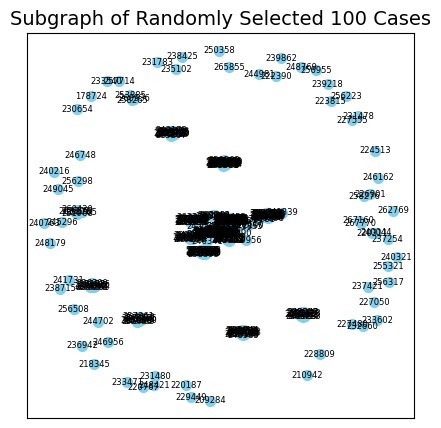

In [18]:

# Ensure graph has enough nodes for sampling
node_list = list(G.nodes)  # Convert NodeView to list
if len(node_list) < 100:
    print("Graph has fewer than 100 nodes; using all nodes.")
    sampled_nodes = node_list
else:
    # Select 100 random nodes
    sampled_nodes = random.sample(node_list, 300)

# Create the subgraph
subgraph = G.subgraph(sampled_nodes)

# Check if the subgraph is disconnected
if not nx.is_connected(subgraph):
    print("The sampled subgraph is disconnected.")

# Visualization
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(subgraph, seed=42)  # Consistent layout
nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color="skyblue")
nx.draw_networkx_edges(subgraph, pos, edge_color="gray")
nx.draw_networkx_labels(
    subgraph, pos, {node: node for node in subgraph.nodes}, font_size=6, font_color="black"
)

plt.title("Subgraph of Randomly Selected 100 Cases", fontsize=14)
plt.show()


In [ ]:
# Visualization
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Positioning nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, edge_color="gray")
nx.draw_networkx_labels(
    G, pos, {node: node for node in G.nodes}, font_size=10, font_color="black"
)

plt.title("Graph of Cases with Identical Judges", fontsize=14)
plt.show()

# Data Analysis

In [12]:
cases_with_judges["JudgeStr"] = cases_with_judges["Judge"].apply(lambda x: ",".join(sorted(x)))
cases_with_judges['Topic'] = cases_with_judges['FreeText'].apply(classify_topic, shortcuts_mapping=shortcuts_mapping_reversed)

['סדר', 'השופט', 'תאריך', '(סמכויות', "י'", 'ד', 'בקשה', 'מעצרים),', 'פלוני', 'ג', 'לפי', 'למעצר', 'מדינת', 'הישיבה:', 'נ', 'סעיף', '-', 'המשיב:', 'אכיפה', 'ישראל']
['סדר', 'השופט', 'תאריך', '(סמכויות', "י'", 'ד', 'בקשה', 'מעצרים),', 'פלוני', 'ג', 'לפי', 'למעצר', 'מדינת', 'הישיבה:', 'נ', 'סעיף', '-', 'המשיב:', 'אכיפה', 'ישראל']
['דיון', 'השופט', 'אוחיון', 'מיום', 'בקשה', 'ד', 'פלוני', 'ג', "ד'", 'מדינת', 'נ', 'לדחיית', 'מועד', 'ישראל', 'עו"ד', 'החלטה', 'לפני:', '2.', 'מינץ', '5.12.2023']
['פסק', 'לממשלה', 'ערעור', 'המשפטי', 'המבקשים', 'על', 'פלונית', 'רשות', 'ד', 'פלוני', 'ג', 'ברק-ארז', 'בקשת', "ד'", 'לשירותים', 'נ', 'מחלקה', 'חברתיים', 'פלונים', 'המבקש:']
['המשפט', 'העליון', 'פלונית', 'בבית', 'ד', 'פלוני', '36958-10-20:', 'ג', 'הנשיאה', 'נ', "א'", 'חיות', '\xad\xad\xad\xadבש"א', 'בת"א', 'לפני:', '2.', 'הנתבע', '1448/22', '1.', '(מחוזי']
['לעיכוב', "ש'", 'גזר', 'של', 'המשפט', 'המשיבה:', 'השופט', 'העליון', 'בבית', 'בשבתו', 'ד', 'בקשה', 'ג', 'משפט', 'מדינת', 'נ', 'ביצוע', 'המבקש:', 'ישר

In [20]:
print(f"Columns: {cases_with_judges.columns}")
print(f"Number of cases: {len(cases_with_judges)}")
print(f"Date Start: {cases_with_judges['CaseStartDate'].min()} - End: {cases_with_judges['CaseStartDate'].max()}")
cases_with_judges.head()

Columns: Index(['ID', 'CaseID', 'CaseNumber', 'Type', 'IsTechnical', 'CaseStartDate',
       'CaseVerdictDate', 'Prosecutor', 'Defendant', 'FreeText',
       'FreeTextWrapped', 'Prosecuted', 'Judge', 'JudgeStr', 'Topic'],
      dtype='object')
Number of cases: 27005
Date Start: 2020-07-26 05:38:35.630000 - End: 2024-11-26 11:09:51.137000


ID  CaseID  CaseNumber     Type  IsTechnical  \
8024   810059  272410        1560    החלטה        False   
8033   810034  262078        6687  פסק-דין        False   
8042   809998  264642          34  פסק-דין        False   
17728  809587  273755       42929    החלטה        False   
11457  809522  273822        2163  פסק-דין        False   

                CaseStartDate         CaseVerdictDate  \
8024  2024-11-26 11:09:51.137 2024-11-26 11:05:53.490   
8033  2024-11-25 20:08:25.403 2024-11-25 19:57:35.667   
8042  2024-11-25 14:52:35.597 2024-11-25 14:38:04.930   
17728 2024-11-20 10:53:18.537 2024-11-20 10:37:36.177   
11457 2024-11-19 14:23:00.123 2024-11-19 14:17:43.103   

                          Prosecutor    Defendant  \
8024   אסום - חברה קבלנית לבנין בע"מ  מדינת ישראל   
8033                    סימון אוחיון  מדינת ישראל   
8042                      שגיא אברבך  מדינת ישראל   
17728                  ארז אקרישבסקי  מדינת ישראל   
11457                          פלוני  מדינת ישראל   

                                                FreeText  \
8024   בבית המשפט העליון רע"פ 1560-10-24 לפני: כבוד ה...   
8033   בבית המשפט העליון ע"פ 6687/23 ע"פ  9059/23 לפנ...   
8042   בבית המשפט העליון ע"פ 34/24 לפני: כבוד השופט א...   
17728  בבית המשפט העליון רעב"ס 42929-11-24 לפני: כבוד...   
11457  בבית המשפט העליון ע"פ 2163/24 לפני: כבוד השופט...   

                                         FreeTextWrapped     Prosecuted  \
8024   בבית המשפט העליון רע"פ 1560-10-24 לפני: כבוד ה...  [מדינת ישראל]   
8033   בבית המשפט העליון ע"פ 6687/23 ע"פ  9059/23 לפנ...  [מדינת ישראל]   
8042   בבית המשפט העליון ע"פ 34/24 לפני: כבוד השופט א...  [מדינת ישראל]   
17728  בבית המשפט העליון רעב"ס 42929-11-24 לפני: כבוד...  [מדינת ישראל]   
11457  בבית המשפט העליון ע"פ 2163/24 לפני: כבוד השופט...  [מדינת ישראל]   

                                                   Judge  \
8024   [כבוד השופטים ל' גליקסמן,, כבוד השופטים ל' גלי...   
8033                             [כבוד השופט ח'אלד כבוב]   
8042                             [כבוד השופט ח'אלד כבוב]   
17728                               [כבוד השופט מ' קרשן]   
11457  [כבוד השופטים ט' חיימוביץ',, כבוד השופטים ט' ח...   

                                                JudgeStr                Topic  
8024   כבוד השופטים ל' גליקסמן,,כבוד השופטים ל' גליקס...     רשות ערעור פלילי  
8033                               כבוד השופט ח'אלד כבוב      ע"פ ערעור פלילי  
8042                               כבוד השופט ח'אלד כבוב      ע"פ ערעור פלילי  
17728                                 כבוד השופט מ' קרשן  רשות ערעור בתי סוהר  
11457  כבוד השופט ב' שגיא.,כבוד השופטים ט' חיימוביץ',...      ע"פ ערעור פלילי

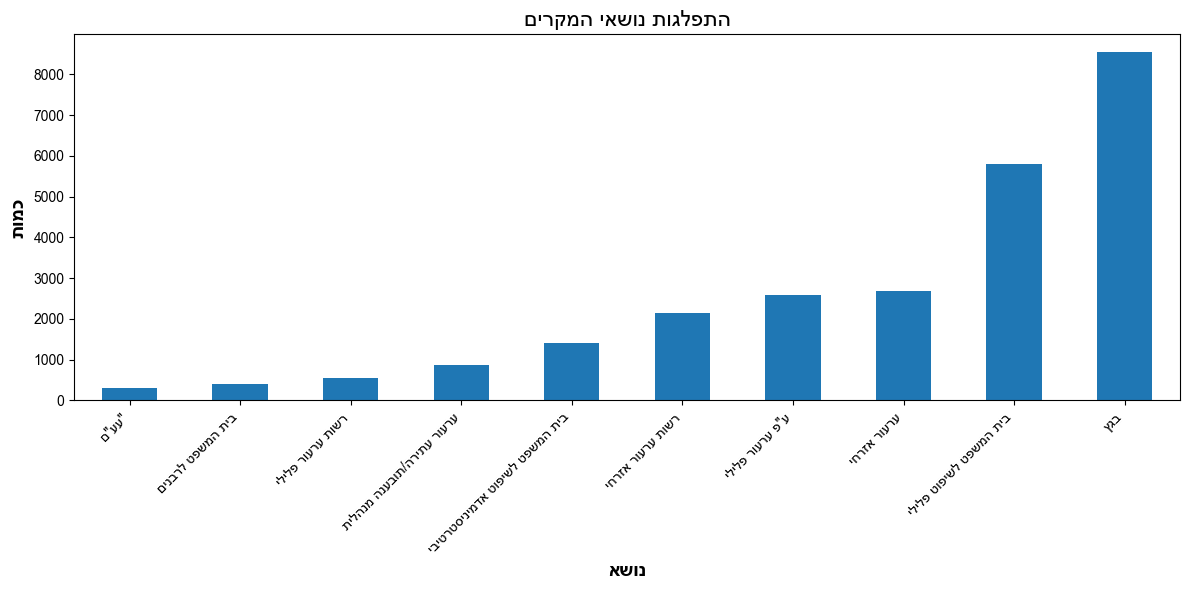

In [21]:
# Plot
cases_with_judges['Topic'].apply(inverse_chars).value_counts().iloc[:10].plot(kind='bar', figsize=(12, 6))
plt.title('התפלגות נושאי המקרים'[::-1], fontsize=16)  # Title in Hebrew
plt.xlabel('נושא'[::-1], fontsize=14)  # X-axis label in Hebrew
plt.ylabel('כמות'[::-1], fontsize=14)  # Y-axis label in Hebrew
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Invert the X-axis if needed for proper alignment
plt.tight_layout()  # Adjust layout
plt.show()


In [22]:
bagatz = cases_with_judges[cases_with_judges['Topic'] == 'בגץ']

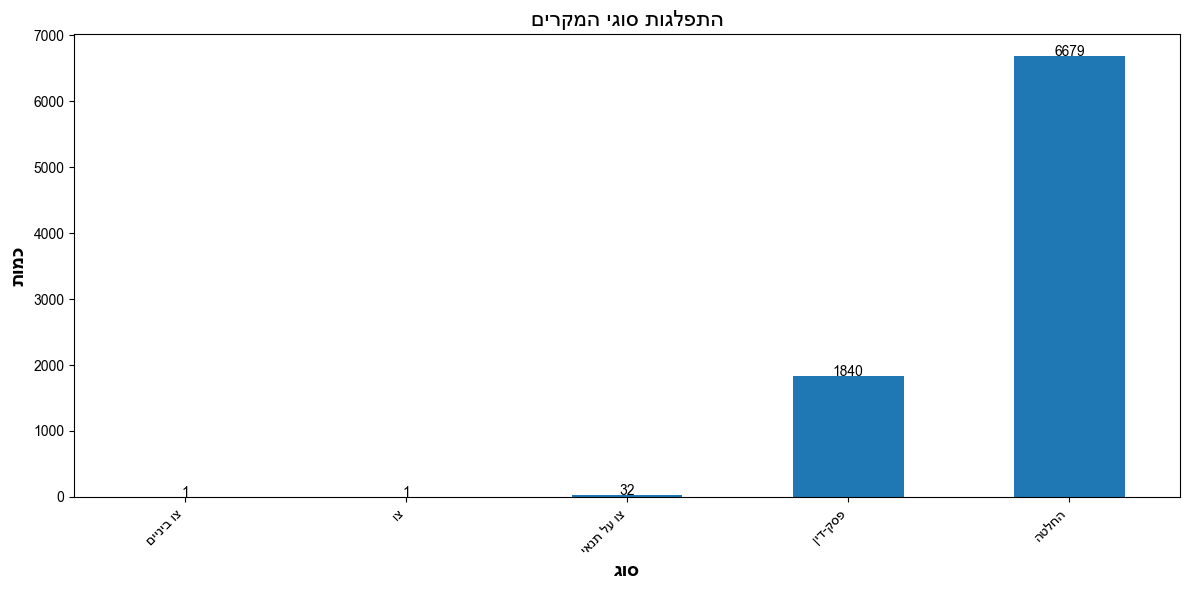

In [23]:
bagatz['Type'].apply(inverse_chars).value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('התפלגות סוגי המקרים'[::-1], fontsize=16)  # Title in Hebrew
plt.xlabel('סוג'[::-1], fontsize=14)  # X-axis label in Hebrew
plt.ylabel('כמות'[::-1], fontsize=14)  # Y-axis label in Hebrew
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Invert the X-axis if needed for proper alignment
# Add value labels
for i, v in enumerate(bagatz['Type'].apply(inverse_chars).value_counts()):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
plt.tight_layout()  # Adjust layout
plt.show()

In [25]:
bagatz_verdicts = bagatz[bagatz['Type'] == 'פסק-דין']

In [ ]:
bagatz_verdicts

In [36]:
from collections import Counter
# Judges count using Counter
judges_count = Counter(bagatz_verdicts['Judge'].explode())

In [45]:
sorted_judges = dict(sorted(judges_count.items(), key=lambda x: x[1], reverse=True))

In [46]:
#reverse chars becuase its in hebrew
sorted_judges = {k[::-1]: v for k, v in sorted_judges.items()}

In [51]:
# Only top 20 judges

top_judges = dict(list(sorted_judges.items())[:20])

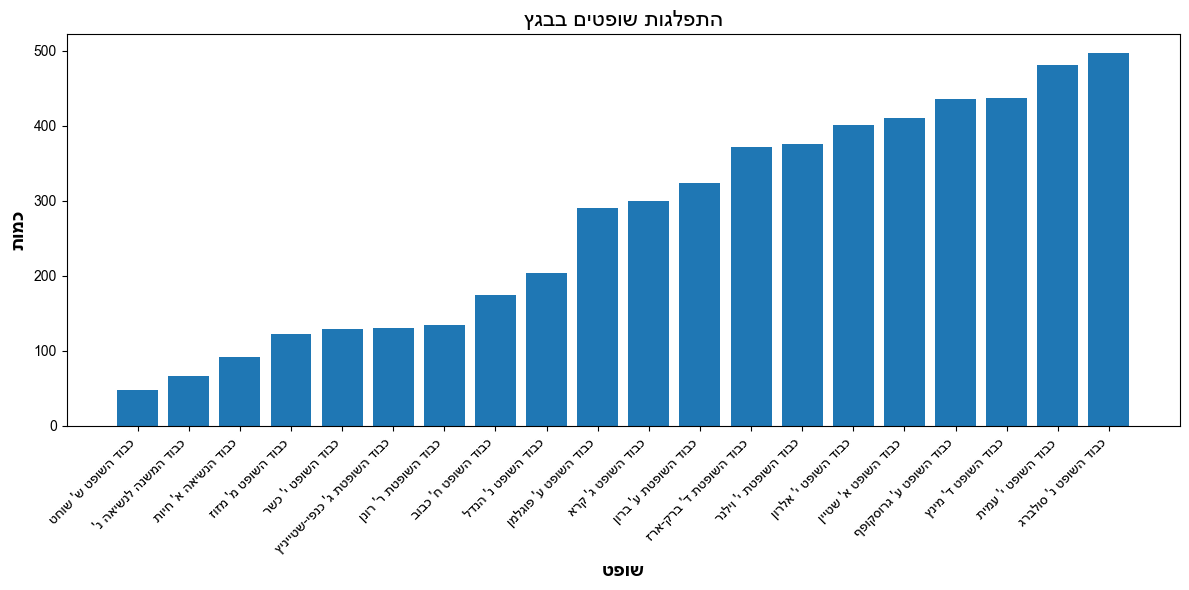

In [52]:
#Plot judges count
plt.figure(figsize=(12, 6))
plt.bar(list(top_judges.keys()), top_judges.values())
plt.title('התפלגות שופטים בבגץ'[::-1], fontsize=16)  # Title in Hebrew
plt.xlabel('שופט'[::-1], fontsize=14)  # X-axis label in Hebrew
plt.ylabel('כמות'[::-1], fontsize=14)  # Y-axis label in Hebrew
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Invert the X-axis if needed for proper alignment
plt.tight_layout()  # Adjust layout
plt.show()



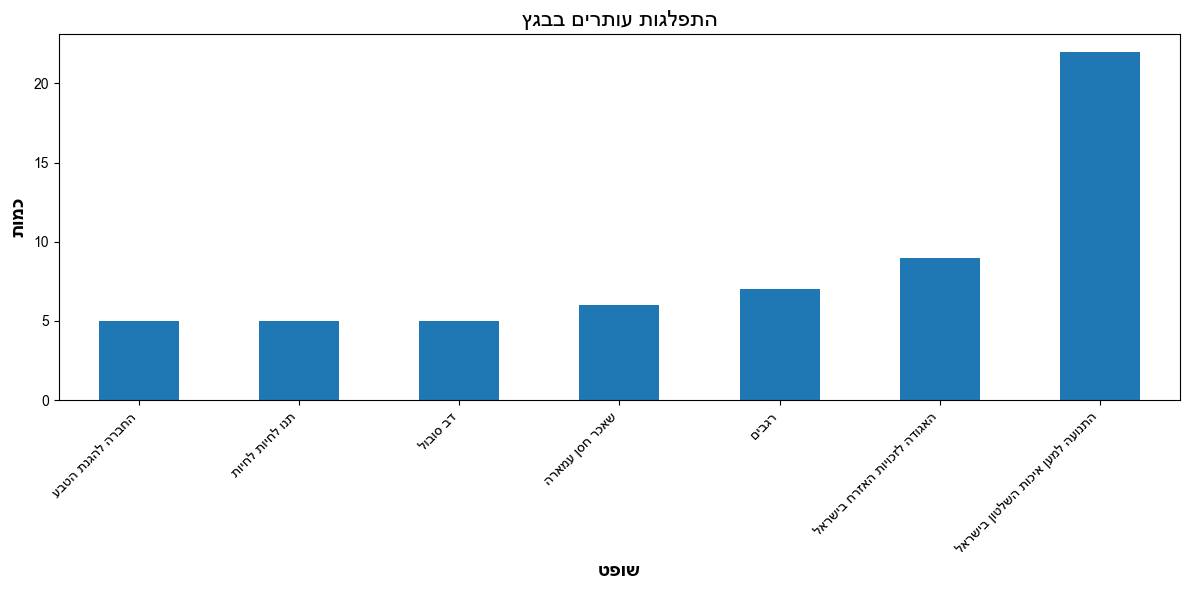

In [57]:
vals = bagatz_verdicts['Prosecutor'].apply(inverse_chars).value_counts()
pol_views = {
  "התנועה למען איכות השלטון בישראל": "Left",
  "האגודה לזכויות האזרח בישראל": "Left",
  "התנועה לטוהר המידות": "Left",
  "קו לעובד": "Left",
  "רגבים": "Right",
  "החברה להגנת הטבע": "Neutral",
  "תנו לחיות לחיות": "Neutral",
  "י.ב שיא משאבים בע\"מ": "Neutral",
  "רופאים לזכויות אדם - ישראל": "Left",
  "התנועה ליהדות מתקדמת בישראל": "Left",
  "בתיה כהנא דרור": "Neutral",
  "שירותי בריאות כללית": "Neutral",
  "עמותת הקנאביס הרפואי": "Neutral",
  "יוסף אבו בסמה": "Neutral",
  "יוסף שלום סולומון": "Neutral",
  "עמותת המצפה לישראל": "Neutral",
  "התאחדות משרדי הנסיעות ויועצי התיירות בישראל": "Neutral",
  "עדאלה - המרכז המשפטי לזכויות המיעוט הערבי בישראל": "Left",
  "תנועת רגבים": "Right",
  "התנועה למען איכות השלטון": "Left",
}

vals = vals[vals >= 5][1:] # Filter judges with fewer than 10 cases
vals.plot(kind='bar', figsize=(12, 6))
plt.title('התפלגות עותרים בבגץ'[::-1], fontsize=16)  # Title in Hebrew
plt.xlabel('שופט'[::-1], fontsize=14)  # X-axis label in Hebrew
plt.ylabel('כמות'[::-1], fontsize=14)  # Y-axis label in Hebrew
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Invert the X-axis if needed for proper alignment
plt.tight_layout()  # Adjust layout
plt.show()


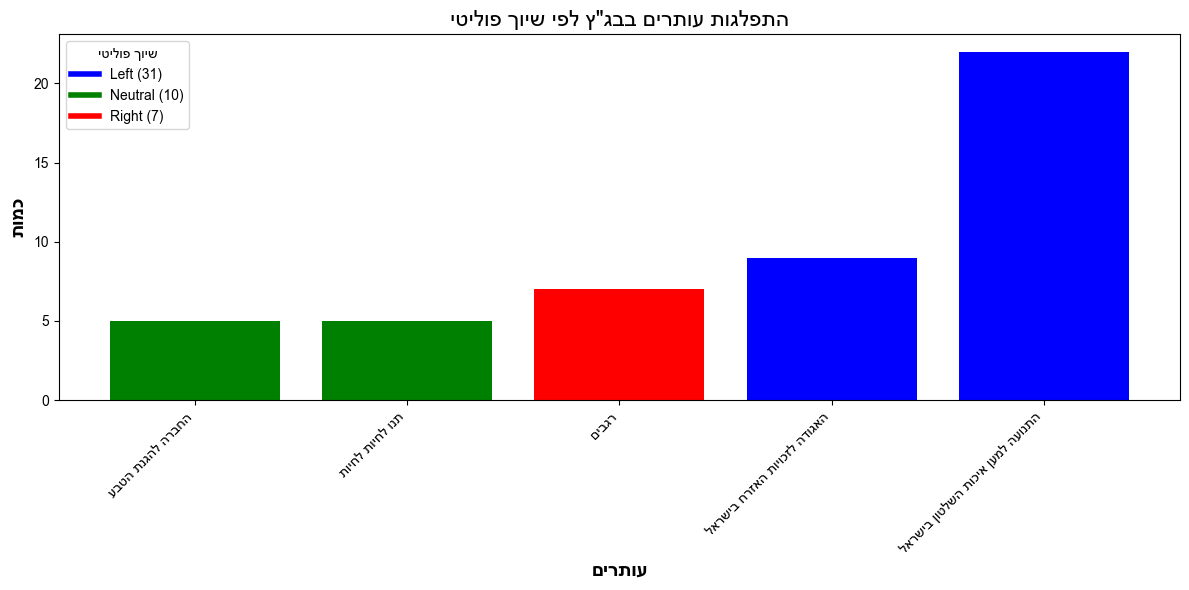

In [58]:
pol_views = {key[::-1]: value for key, value in pol_views.items()}# Define colors for political views
pol_colors = {
    "Left": "blue",
    "Right": "red",
    "Neutral": "green"
}

# Map political views to colors
vals_colored = vals.reset_index()
vals_colored.columns = ['Prosecutor', 'Count']
vals_colored['PolView'] = vals_colored['Prosecutor'].map(pol_views)
vals_colored['Color'] = vals_colored['PolView'].map(pol_colors)
# Filter out rows with missing colors
vals_colored_filtered = vals_colored.dropna(subset=['Color'])
# Calculate totals for each political view
total_counts = vals_colored.groupby('PolView')['Count'].sum()
# Plot the bars
plt.figure(figsize=(12, 6))
plt.bar(vals_colored_filtered['Prosecutor'], vals_colored_filtered['Count'], color=vals_colored_filtered['Color'])

# Add title and labels
plt.title('התפלגות עותרים בבג"ץ לפי שיוך פוליטי'[::-1], fontsize=16)
plt.xlabel('עותרים'[::-1], fontsize=14)
plt.ylabel('כמות'[::-1], fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Optional: Invert X-axis for alignment

# Fix for legend mapping
# Ensure all PolView values have a color
default_color = "gray"  # Fallback color for undefined PolViews
total_counts_with_colors = {
    view: (total_counts[view], pol_colors.get(view, default_color))
    for view in total_counts.index
}

# Add legend
handles = [
    plt.Line2D([0], [0], color=color, lw=4, label=f'{view} ({count})')
    for view, (count, color) in total_counts_with_colors.items()
]
plt.legend(handles=handles, title='שיוך פוליטי'[::-1], loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


In [354]:
reversed = [x[::-1] for x in vals.index.tolist()]

In [59]:
# Extracting Verdicts from Text using regex
bagatz['Verdict'] = bagatz['FreeText'].apply(extract_verdict)
# Extracting Entities using NER
bagatz['Entitys'] = bagatz['FreeTextWrapped'].apply(lambda x: extract_orgs_using_ner(NER, x))

/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/1012599757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['Verdict'] = bagatz['FreeText'].apply(extract_verdict)
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/1012599757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['Entitys'] = bagatz['FreeTextWrapped'].apply(l

In [61]:
bagatz_verdicts = bagatz[bagatz['Type'] == 'פסק-דין']

In [88]:
accepted_left = filter_cases(bagatz_verdicts, Verdict=["Accepted"], Prosecutor=['התנועה למען איכות השלטון בישראל'])
accepted_right = filter_cases(bagatz_verdicts, Verdict=["Accepted"], Prosecutor=['רגבים'])
accepted_left_2 = filter_cases(bagatz_verdicts, Verdict=["Accepted"], Prosecutor=['האגודה לזכויות האזרח בישראל'])


In [85]:
print_wrapped_text(accepted_left['FreeTextWrapped'].iloc[1])

################################################
בבית המשפט העליון בשבתו כבית משפט    גבוה לצדק בג"ץ  3056/20 בג"ץ  5920/20 לפני: כבוד הנשיאה א' חיות
כבוד המשנה לנשיאה ח' מלצר כבוד השופט נ' הנדל העותרת בבג"ץ 3056/20: העותרים בבג"ץ 5920/20: התנועה
למען איכות השלטון בישראל יורם יעקובי ו-68 אח' נ  ג  ד המשיבים בבג"ץ 3056/20: 1. היועץ המשפטי לממשלה
2. ראש הממשלה המשיבים בבג"ץ 5920/20: 3. השר לביטחון הפנים 1. היועץ המשפטי לממשלה 2. ראש הממשלה 3. שר
הביטחון וראש הממשלה החלופי 4. השר לביטחון הפנים התנגדות לעשיית הצו    על תנאי לצו מוחלט תאריכי
הישיבות: כ"ה בחשון התשפ"א (12.11.2020) ו' באדר התשפ"א (18.2.2021) בשם העותרת בבג"ץ 3056/20: בשם
העותרים בבג"ץ 5920/20: בשם המשיבים 1 ו-3 בבג"ץ 3056/20 ובשם המשיבים 1, 3    ו-4 בבג"ץ 5920/20: בשם
המשיב 2 בבג"ץ 3056/20 ובבג"ץ 5920/20: עו"ד אליעד שרגא; עו"ד תומר    נאור; עו"ד הידי נגב עו"ד דפנה
הולץ-לכנר עו"ד ליאורה וייס-בנסקי;    עו"ד יונתן ברמן; עו"ד סיון דגן עו"ד מיכאל ראבילו; עו"ד    יוסי
כהן; עו"ד רועי שכטר; עו"ד אופק ברוק פסק-דין הנשיאה א' חיות: האם 

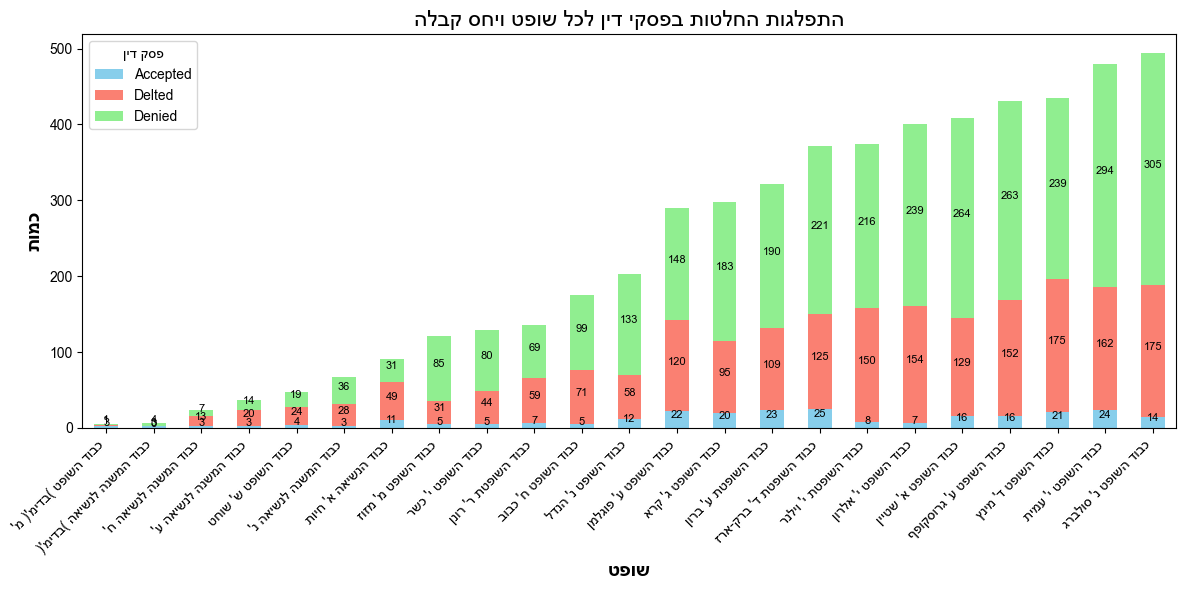

In [125]:
import matplotlib.pyplot as plt

# Filter the cases
bagaz = filter_cases(bagatz_verdicts, Verdict=["Denied", "Accepted", "Delted"])
# Filter the cases for relevant verdicts

# Explode the Judge column to count each judge individually
bagaz_exploded = bagaz.explode("Judge")

# Create a pivot table to get counts of verdicts per judge
verdict_counts = bagaz_exploded.pivot_table(index='Judge', columns='Verdict', aggfunc='size', fill_value=0)

verdict_counts['Ratio'] = verdict_counts['Accepted'] / (verdict_counts['Accepted'] + verdict_counts['Denied'] + verdict_counts['Delted'])*100
verdict_counts['Total'] = verdict_counts['Accepted'] + verdict_counts['Denied'] + verdict_counts['Delted']

# Sort the judges RTL (reverse order)
verdict_counts = round(verdict_counts.sort_values(by='Total', ascending=False),1)
# Drop columns of ratio and total
verdict_counts = verdict_counts.drop(columns=['Ratio', 'Total'])

verdict_counts = verdict_counts.iloc[::-1]

# Reverse Hebrew labels for judges
verdict_counts.index = verdict_counts.index.map(inverse_chars)

verdict_counts = verdict_counts[verdict_counts['Accepted'] > 1]
# Plot the stacked bar chart
ax = verdict_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=["skyblue", "salmon", "lightgreen"])

# Set plot title and labels in Hebrew
ax.set_title(inverse_chars('התפלגות החלטות בפסקי דין לכל שופט ויחס קבלה'), fontsize=16)  # Reverse Hebrew title
ax.set_xlabel(inverse_chars('שופט'), fontsize=14)  # Reverse "Judge" for label
ax.set_ylabel(inverse_chars('כמות'), fontsize=14)  # Reverse "Count" for label

# Add legend in Hebrew
ax.legend(title=inverse_chars('פסק דין'), loc="upper left", fontsize=10)  # Reverse "Verdict" for legend title

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8, padding=3)

# Adjust tick labels for Hebrew
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=45, ha="right")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:


bagatz['Locations'] = bagatz['FreeTextWrapped'].apply(extract_locations)

/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/1348120981.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['Locations'] = bagatz['FreeTextWrapped'].apply(extract_locations)


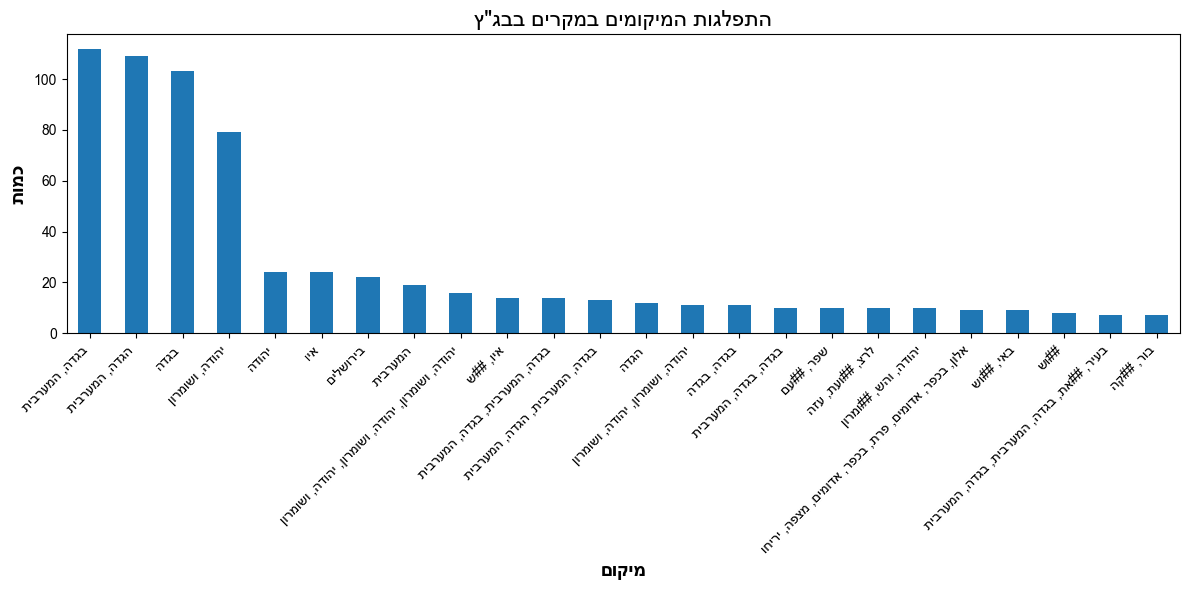

In [ ]:
bagatz['Locations'].value_counts().head(25)[1:].plot(kind='bar', figsize=(12, 6))
# Reverse labels for Hebrew
for label in plt.gca().get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# Iterate the text and inverse it for each label
plt.gca().set_xticklabels([inverse_chars(label.get_text().replace("[","").replace("]","")) for label in plt.gca().get_xticklabels()])
plt.title('התפלגות המיקומים במקרים בבג"ץ'[::-1], fontsize=16)
plt.xlabel('מיקום'[::-1], fontsize=14)
plt.ylabel('כמות'[::-1], fontsize=14)
plt.tight_layout()


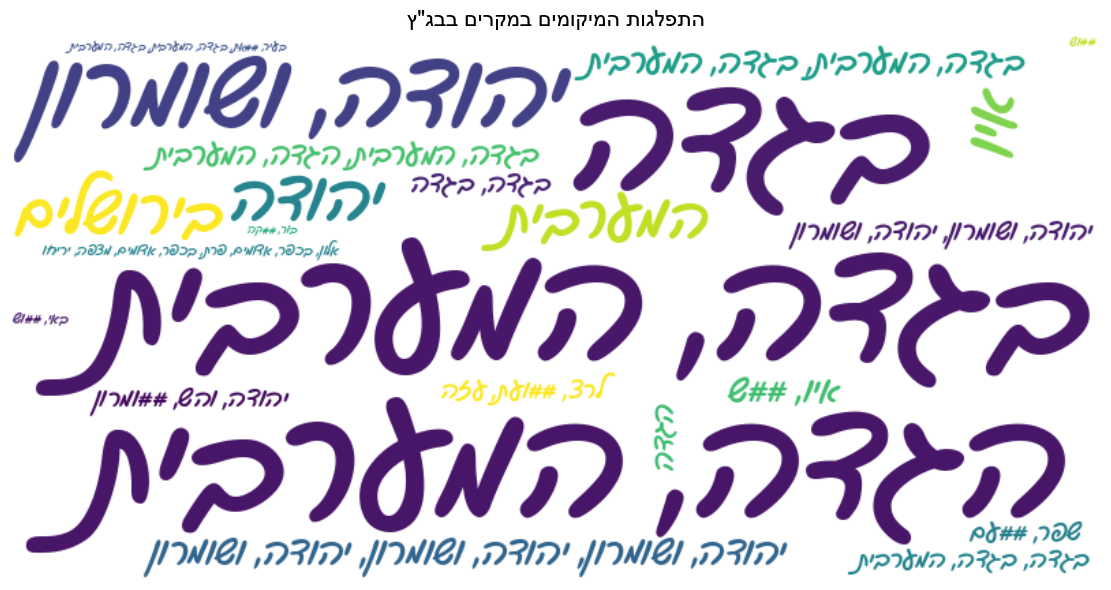

In [141]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the frequency dictionary for the top 25 locations (excluding the first one)
location_counts = bagatz['LocationStr'].value_counts().head(25)[1:].to_dict()

# Create a word cloud
wordcloud = WordCloud(
    font_path=r'/Users/adirserruya/Projects/BigDataMining/MishpatScraper/Gveret Levin Alef Alef Alef.ttf',  # Path to Arial font
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'  # Change the colormap if needed
).generate_from_frequencies(location_counts)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('התפלגות המיקומים במקרים בבג"ץ'[::-1], fontsize=16)  # Reverse title for Hebrew
plt.tight_layout()
plt.show()


In [142]:
bagatz['CaseStartDate'] = pd.to_datetime(bagatz['CaseStartDate'])
bagatz['Year'] = bagatz['CaseStartDate'].dt.year
bagatz['Month'] = bagatz['CaseStartDate'].dt.month
bagatz['Day'] = bagatz['CaseStartDate'].dt.day
# Add week of year
bagatz['Week'] = bagatz['CaseStartDate'].dt.isocalendar().week



/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/3931338960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['CaseStartDate'] = pd.to_datetime(bagatz['CaseStartDate'])
/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/3931338960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['Year'] = bagatz['CaseStartDate'].dt.year
/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/3931338960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

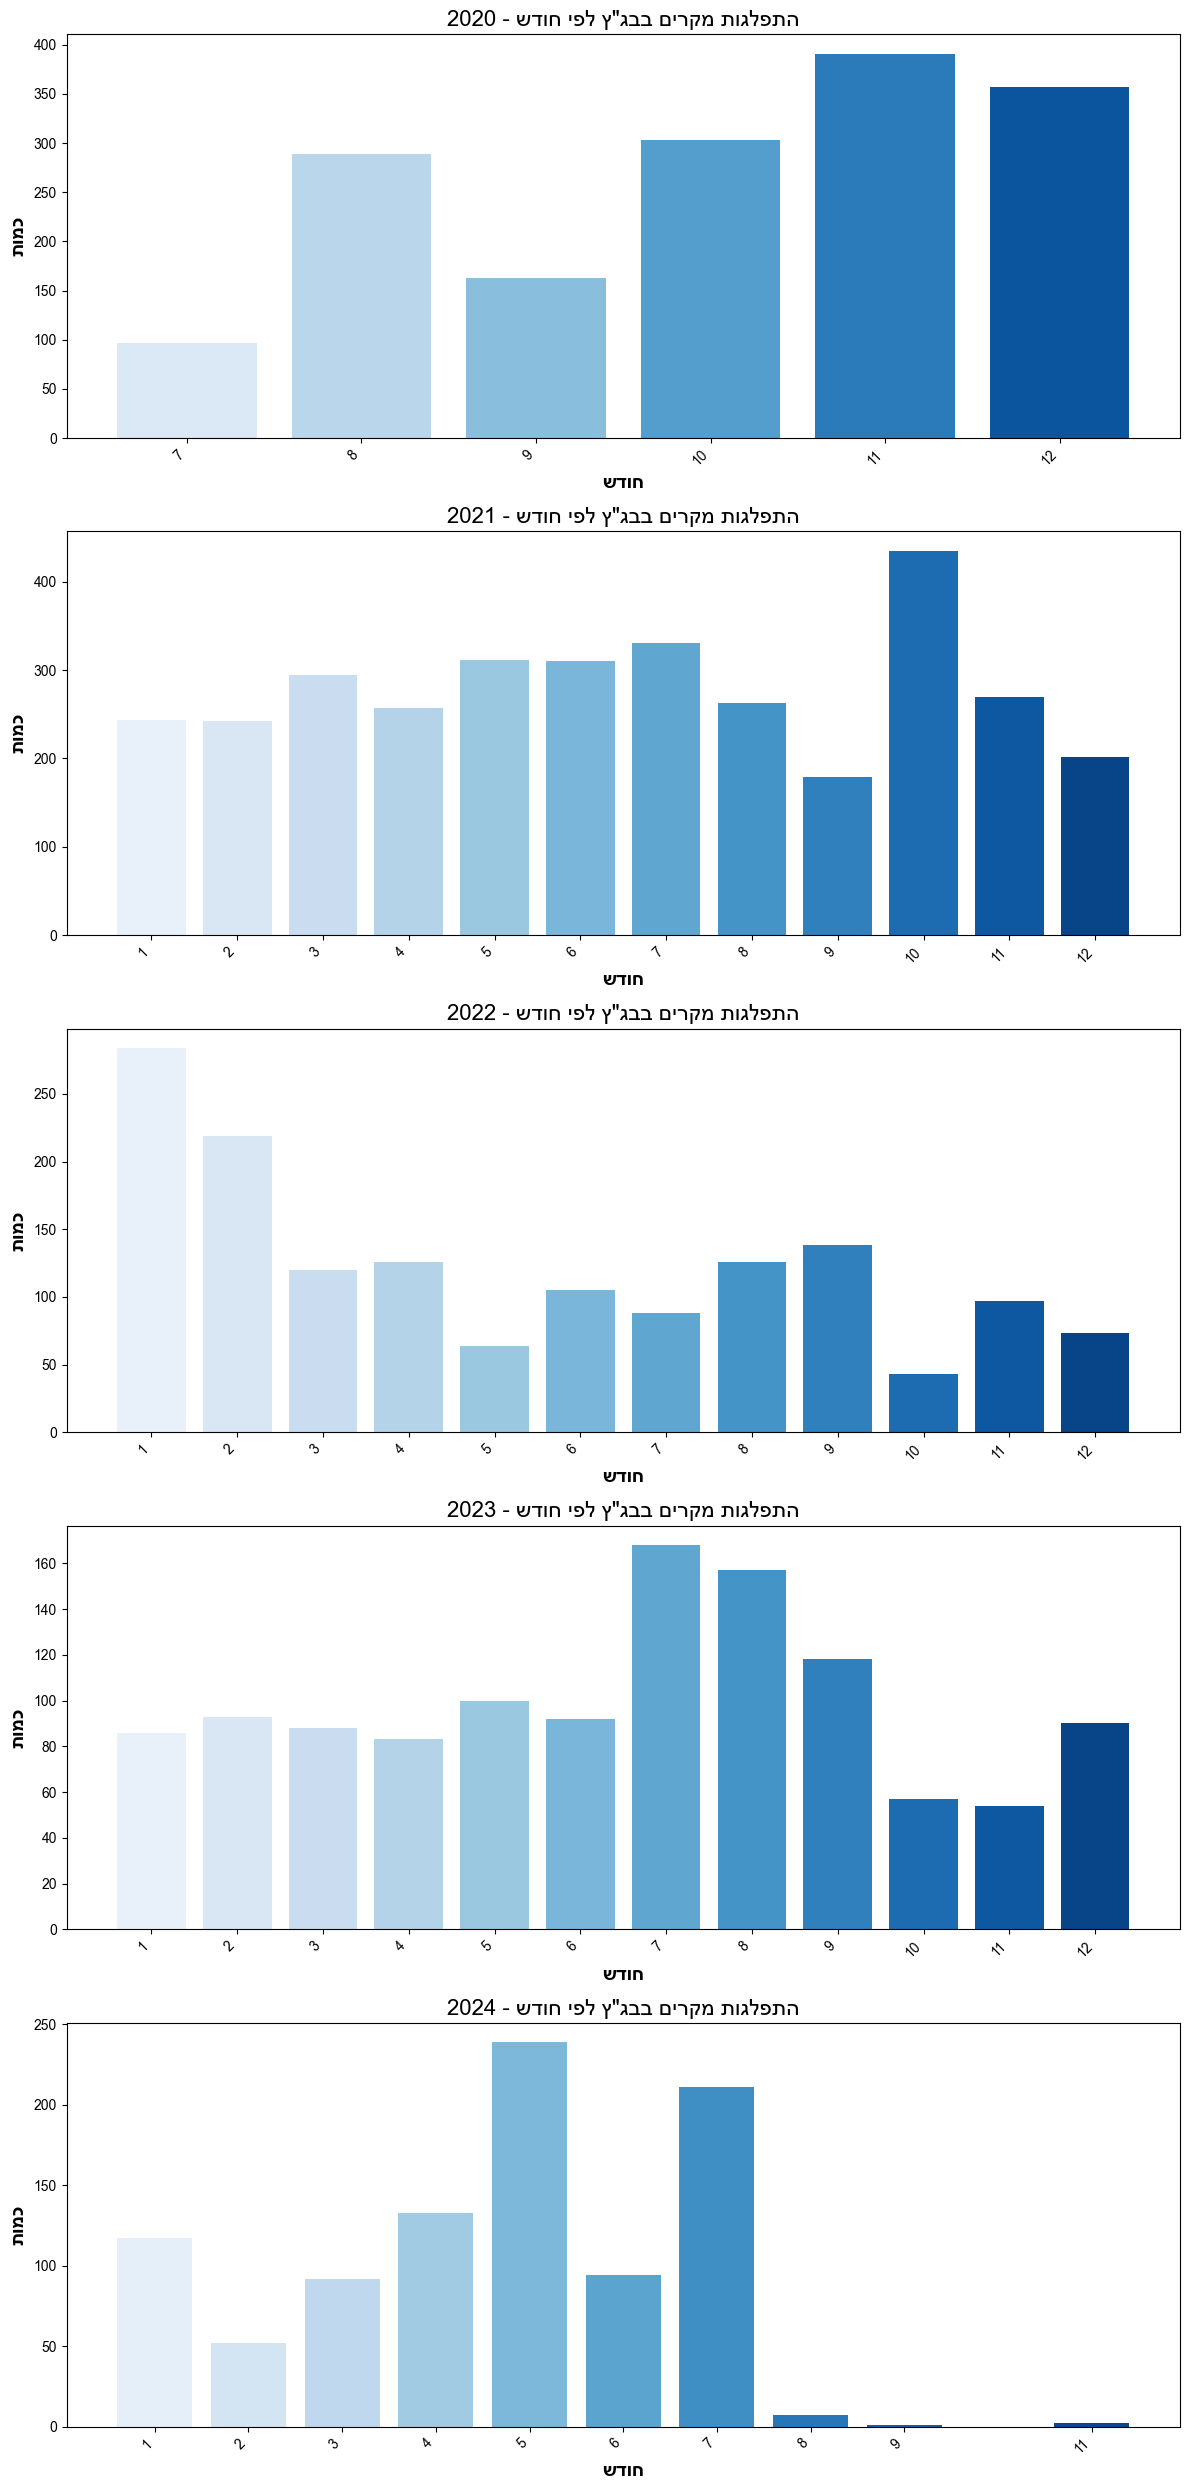

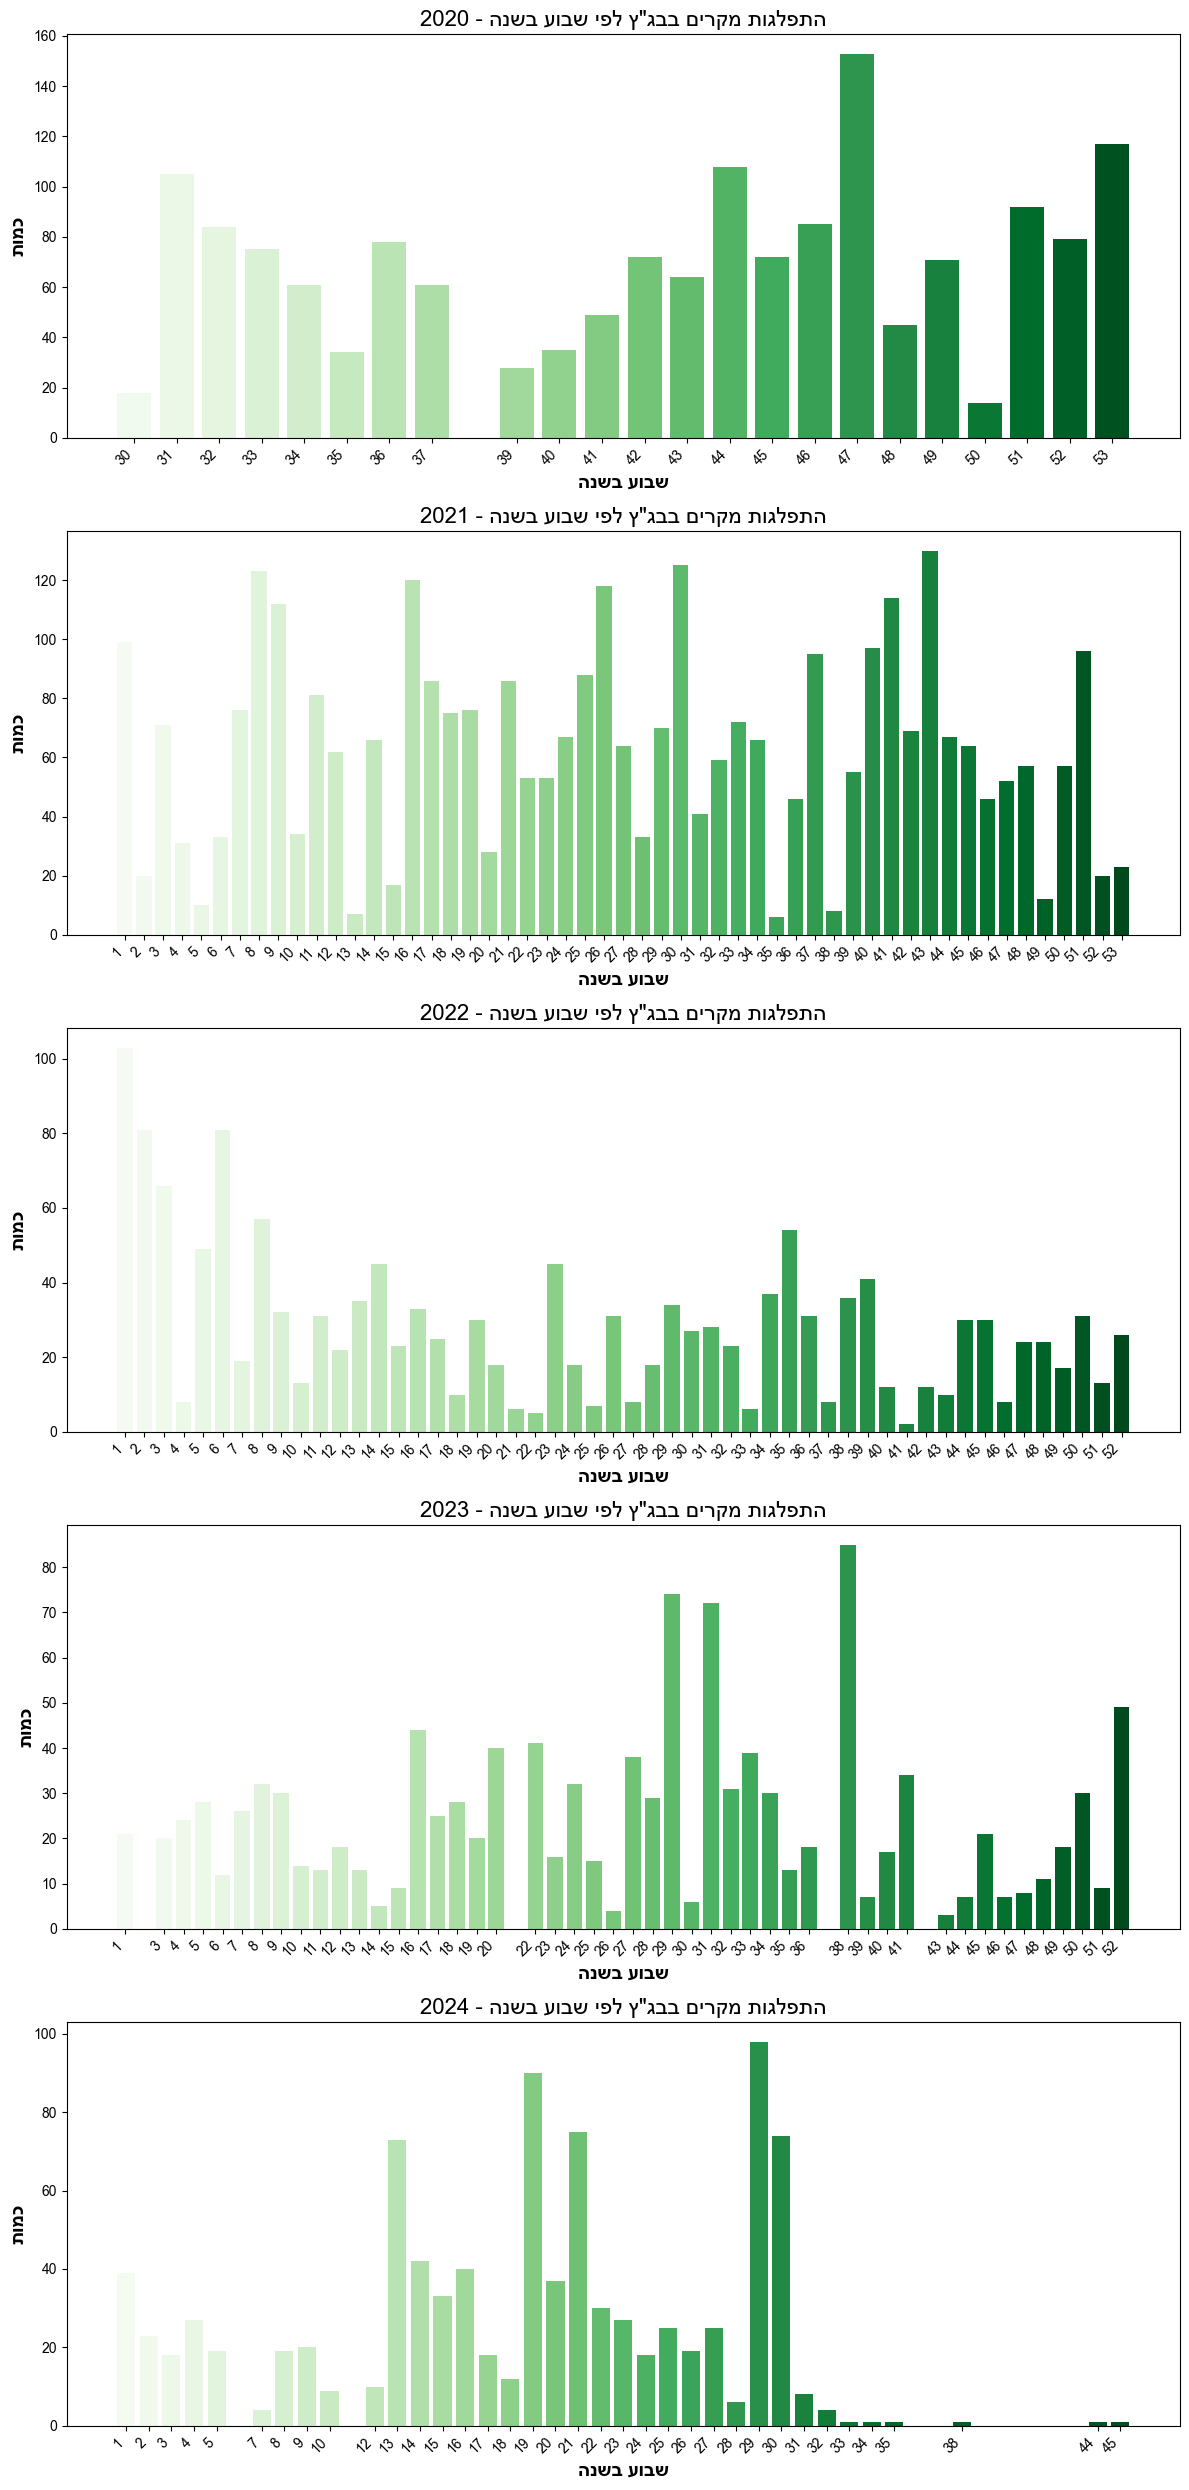

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a professional color palette
sns.set_palette("Blues")  # You can try "Blues", "Greens", etc.

# Group data
cases_per_month = bagatz.groupby(['Year', 'Month']).size()
cases_per_week = bagatz.groupby(['Year', 'Week']).size()

# Unique years in the dataset
years = bagatz['Year'].unique()

# Plot 1: Cases per Month (Separate Plot for Each Year)
fig, axes = plt.subplots(len(years), 1, figsize=(12, 5 * len(years)))
for idx, year in enumerate(sorted(years)):
    year_data = cases_per_month.loc[year] if year in cases_per_month.index else None
    if year_data is not None:
        axes[idx].bar(year_data.index, year_data.values, color=sns.color_palette("Blues", len(year_data)))
        axes[idx].set_title(f'{year} - {inverse_chars("""התפלגות מקרים בבג"ץ לפי חודש""")}', fontsize=16)
        axes[idx].set_xlabel(inverse_chars('חודש'), fontsize=14)
        axes[idx].set_ylabel(inverse_chars('כמות'), fontsize=14)
        axes[idx].set_xticks(year_data.index)  # Use exact months in the data
        axes[idx].set_xticklabels([str(month) for month in year_data.index], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 2: Cases per Week of the Year (Separate Plot for Each Year)
fig, axes = plt.subplots(len(years), 1, figsize=(12, 5 * len(years)))
for idx, year in enumerate(sorted(years)):
    year_data = cases_per_week.loc[year] if year in cases_per_week.index else None
    if year_data is not None:
        axes[idx].bar(year_data.index, year_data.values, color=sns.color_palette("Greens", len(year_data)))
        axes[idx].set_title(f'{year} - {inverse_chars("""התפלגות מקרים בבג"ץ לפי שבוע בשנה""")}', fontsize=16)
        axes[idx].set_xlabel(inverse_chars('שבוע בשנה'), fontsize=14)
        axes[idx].set_ylabel(inverse_chars('כמות'), fontsize=14)
        axes[idx].set_xticks(year_data.index)  # Use exact weeks in the data
        axes[idx].set_xticklabels(
            [str(week) for week in year_data.index],
            rotation=45,
            ha='right'
        )
plt.tight_layout()
plt.show()


In [148]:
bagatz.to_csv('bagatz_full.csv', index=False)

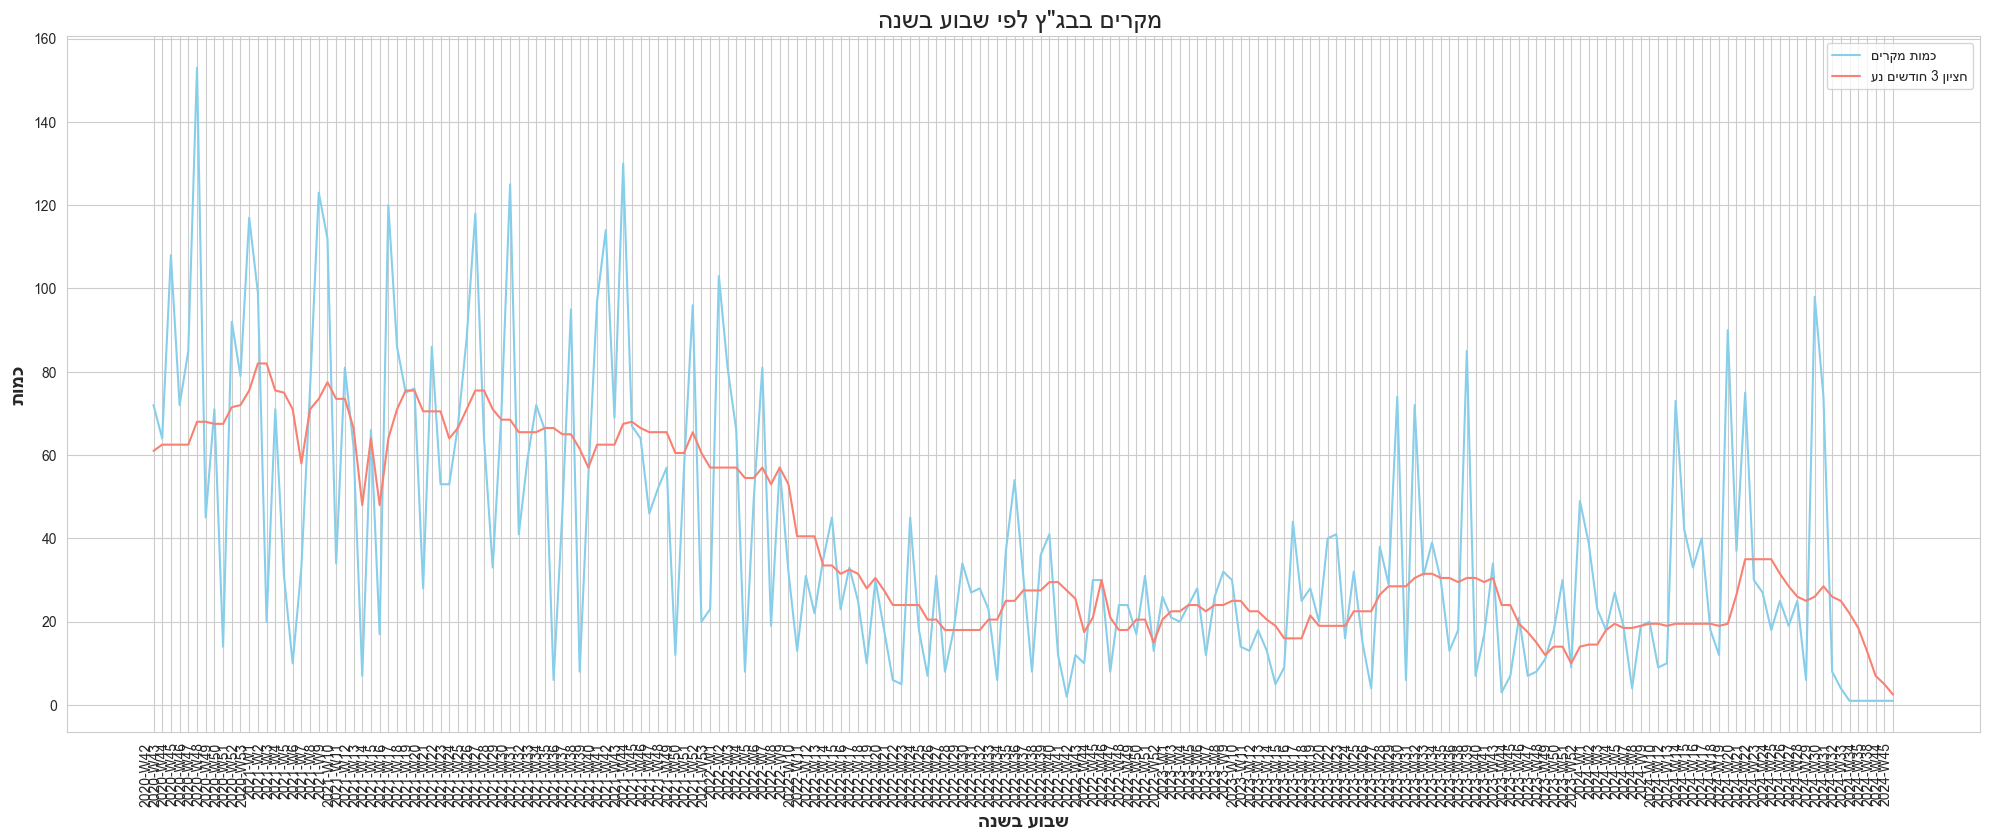

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by Year and WeekOfYear
cases_per_week = bagatz.groupby(['Year', 'Week']).size().reset_index(name='Count')
cases_per_week['Date'] = cases_per_week.apply(lambda x: f"{x['Year']}-W{x['Week']}", axis=1)
cases_per_week['RunningMedian'] = cases_per_week['Count'].rolling(window=12).median()
cases_per_week.dropna(inplace=True)
# Set plot style
sns.set_style("whitegrid")

# Plot time series
plt.figure(figsize=(20, 8))
sns.lineplot(data=cases_per_week, x='Date', y='Count',color='skyblue', label='כמות מקרים'[::-1])

# Add labels and title
plt.title(' מקרים בבג"ץ לפי שבוע בשנה'[::-1], fontsize=18)
plt.xlabel('שבוע בשנה'[::-1], fontsize=14)
plt.ylabel('כמות'[::-1], fontsize=14)
plt.legend(title='שנה'[::-1], fontsize=12)
plt.tight_layout()
# Rotate x-axis labels
plt.xticks(rotation=90, ha='right')
# Add running median
plt.plot(cases_per_week['Date'], cases_per_week['RunningMedian'], color='salmon', label='חציון 3 חודשים נע'[::-1])
# Show the plot
plt.legend()
plt.show()


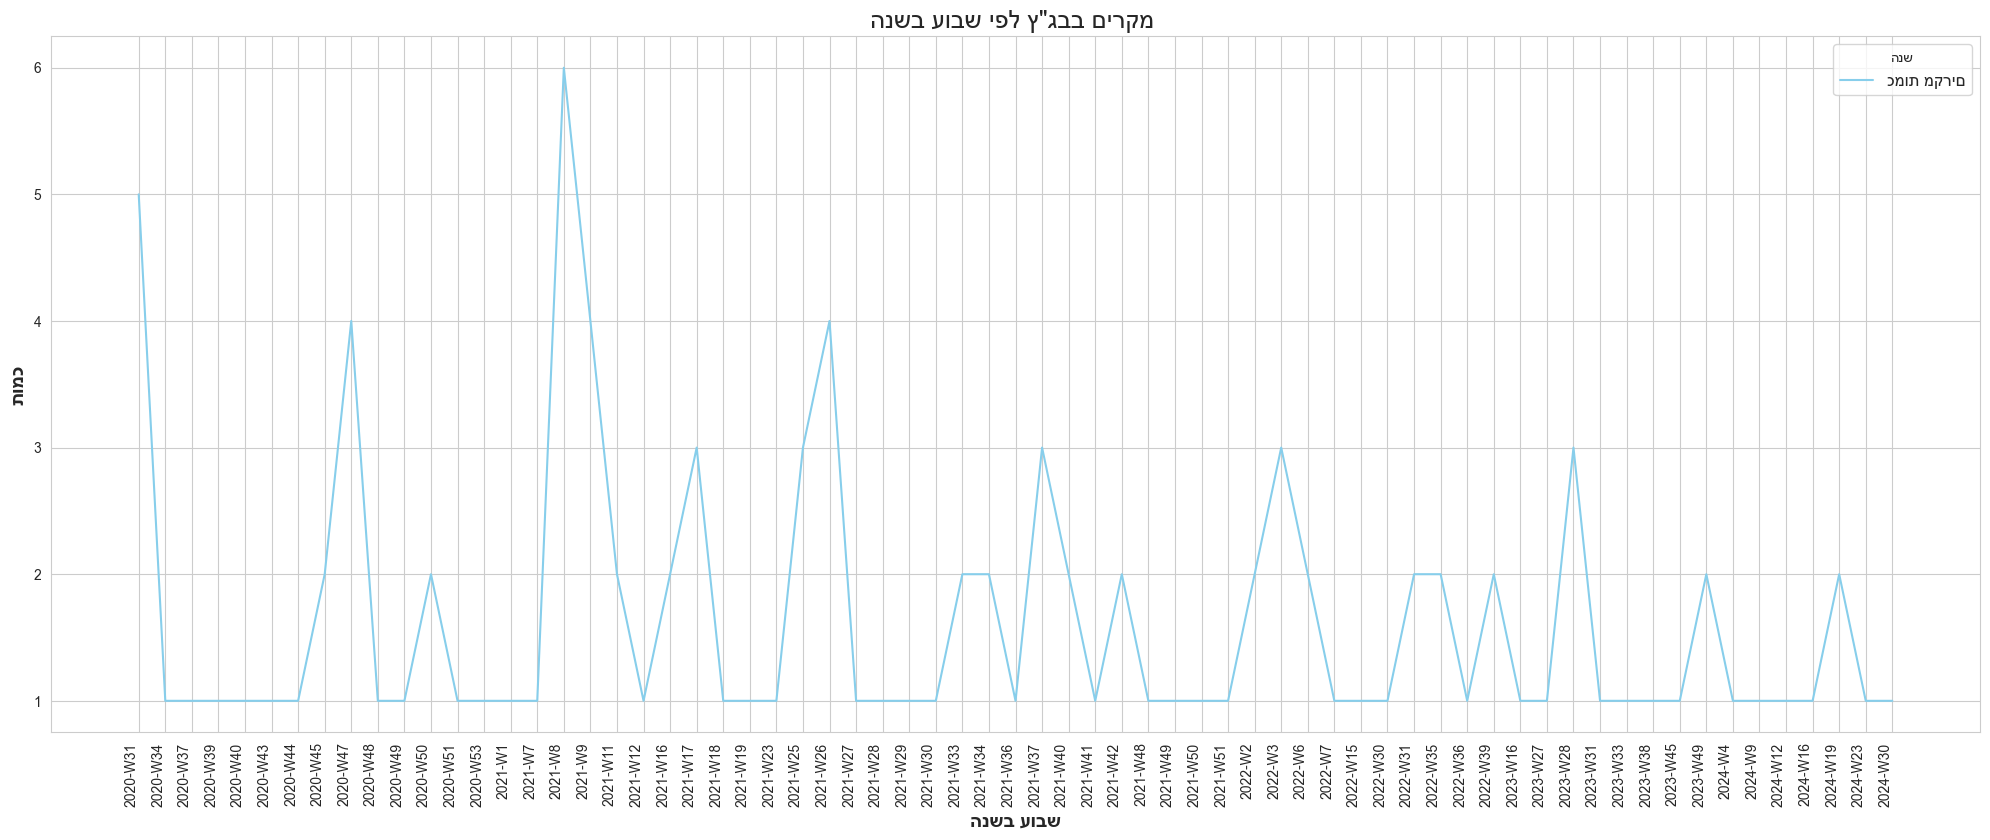

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by Year and WeekOfYear
cases_per_week = bagatz[bagatz['Verdict'] == 'Accepted'].groupby(['Year', 'Week']).size().reset_index(name='Count')
cases_per_week['Date'] = cases_per_week.apply(lambda x: f"{x['Year']}-W{x['Week']}", axis=1)

# Set plot style
sns.set_style("whitegrid")

# Plot time series
plt.figure(figsize=(20, 8))
sns.lineplot(data=cases_per_week, x='Date', y='Count',color='skyblue', label='כמות מקרים')

# Add labels and title
plt.title(' מקרים בבג"ץ לפי שבוע בשנה'[::-1], fontsize=18)
plt.xlabel('שבוע בשנה'[::-1], fontsize=14)
plt.ylabel('כמות'[::-1], fontsize=14)
plt.legend(title='שנה'[::-1], fontsize=12)
plt.tight_layout()
# Rotate x-axis labels
plt.xticks(rotation=90, ha='right')
# Add running median
# Show the plot
plt.show()


In [ ]:
import openai
import requests
from typing import List, Dict




# Example Usage
hebrew_text = ""  # Replace with your text
result = classify_text(client,hebrew_text)
print(f"Classification: {result}")


Classification: ChatCompletion(id='chatcmpl-AlbczJQH3whQ5BVPcP4fdkqljq6K5', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Neutral', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1735909421, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=2, prompt_tokens=73, total_tokens=75, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


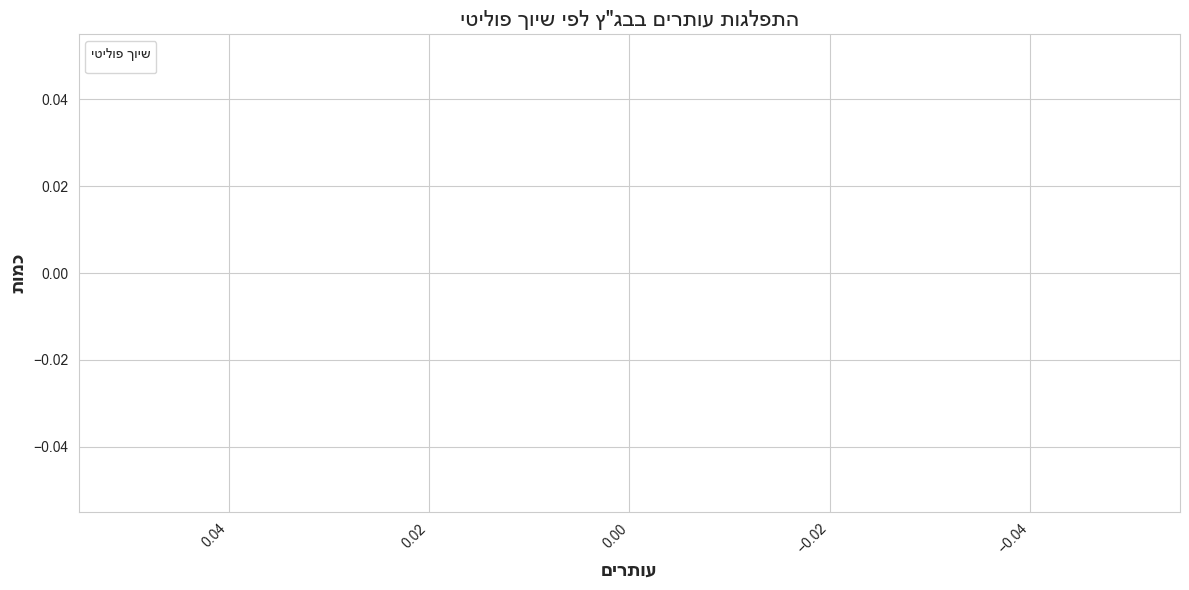

In [158]:
pol_views = {key[::-1]: value for key, value in pol_views.items()}# Define colors for political views
pol_colors = {
    "Left": "blue",
    "Right": "red",
    "Neutral": "green"
}

# Map political views to colors
vals_colored = vals.reset_index()
vals_colored.columns = ['Prosecutor', 'Count']
vals_colored['PolView'] = vals_colored['Prosecutor'].map(pol_views)
vals_colored['Color'] = vals_colored['PolView'].map(pol_colors)
# Filter out rows with missing colors
vals_colored_filtered = vals_colored.dropna(subset=['Color'])
# Calculate totals for each political view
total_counts = vals_colored.groupby('PolView')['Count'].sum()
# Plot the bars
plt.figure(figsize=(12, 6))
plt.bar(vals_colored_filtered['Prosecutor'], vals_colored_filtered['Count'], color=vals_colored_filtered['Color'])

# Add title and labels
plt.title('התפלגות עותרים בבג"ץ לפי שיוך פוליטי'[::-1], fontsize=16)
plt.xlabel('עותרים'[::-1], fontsize=14)
plt.ylabel('כמות'[::-1], fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate and align labels
plt.gca().invert_xaxis()  # Optional: Invert X-axis for alignment

# Fix for legend mapping
# Ensure all PolView values have a color
default_color = "gray"  # Fallback color for undefined PolViews
total_counts_with_colors = {
    view: (total_counts[view], pol_colors.get(view, default_color))
    for view in total_counts.index
}

# Add legend
handles = [
    plt.Line2D([0], [0], color=color, lw=4, label=f'{view} ({count})')
    for view, (count, color) in total_counts_with_colors.items()
]
plt.legend(handles=handles, title='שיוך פוליטי'[::-1], loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


In [162]:
pol_views = {key[::-1]: value for key, value in pol_views.items()}# Define colors for political views
pol_views

{'התנועה למען איכות השלטון בישראל': 'Left',
 'האגודה לזכויות האזרח בישראל': 'Left',
 'התנועה לטוהר המידות': 'Left',
 'קו לעובד': 'Left',
 'רגבים': 'Right',
 'החברה להגנת הטבע': 'Neutral',
 'תנו לחיות לחיות': 'Neutral',
 'י.ב שיא משאבים בע"מ': 'Neutral',
 'רופאים לזכויות אדם - ישראל': 'Left',
 'התנועה ליהדות מתקדמת בישראל': 'Left',
 'בתיה כהנא דרור': 'Neutral',
 'שירותי בריאות כללית': 'Neutral',
 'עמותת הקנאביס הרפואי': 'Neutral',
 'יוסף אבו בסמה': 'Neutral',
 'יוסף שלום סולומון': 'Neutral',
 'עמותת המצפה לישראל': 'Neutral',
 'התאחדות משרדי הנסיעות ויועצי התיירות בישראל': 'Neutral',
 'עדאלה - המרכז המשפטי לזכויות המיעוט הערבי בישראל': 'Left',
 'תנועת רגבים': 'Right',
 'התנועה למען איכות השלטון': 'Left'}

In [163]:
bagatz['PoliticalView'] = bagatz['Prosecutor'].map(pol_views)
bagatz.fillna('Unknown', inplace=True)

/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/1403807134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz['PoliticalView'] = bagatz['Prosecutor'].map(pol_views)
/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_33686/1403807134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bagatz.fillna('Unknown', inplace=True)


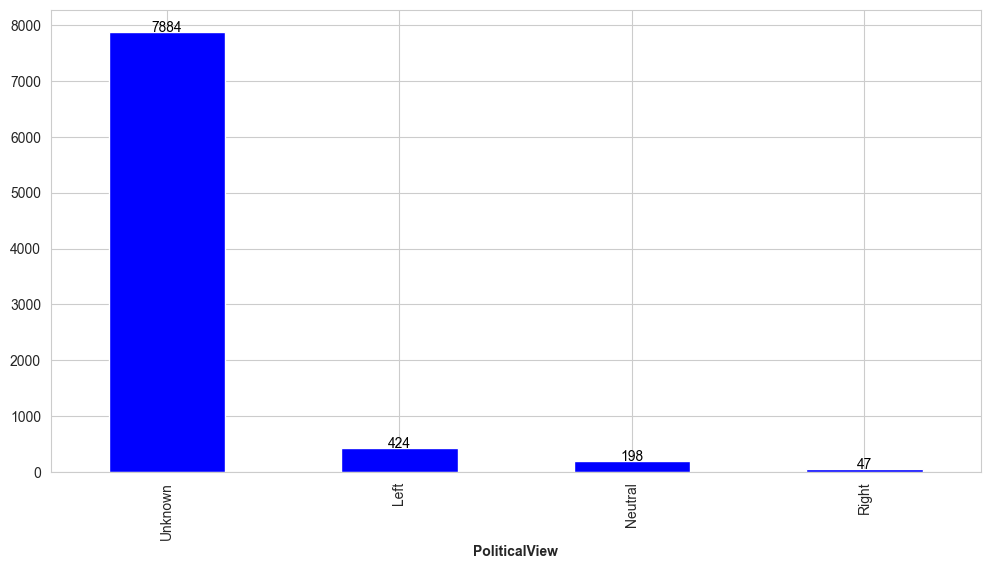

In [164]:
bagatz['PoliticalView'].value_counts().plot(kind='bar', figsize=(12, 6),color='blue')
# Add value labels
for i, v in enumerate(bagatz['PoliticalView'].value_counts()):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
    

In [165]:
# Grab all the cases with political views != 'Unknown'
cases_with_political_views = bagatz[bagatz['PoliticalView'] != 'Unknown']

In [166]:
cases_with_political_views

ID  CaseID  CaseNumber   Type  IsTechnical           CaseStartDate  \
7423   803530  266304        1711  החלטה         True 2024-08-29 06:24:23.543   
34887  801941  268844        4268  החלטה        False 2024-08-07 12:09:05.557   
12187  801456  270476        5908  החלטה         True 2024-07-29 06:00:18.137   
4856   801047  259354        3945  החלטה         True 2024-07-23 15:48:54.653   
4858   801044  267448        2858  החלטה        False 2024-07-23 15:01:33.037   
...       ...     ...         ...    ...          ...                     ...   
7121   682368  231011        2920  החלטה         True 2020-08-02 09:21:31.947   
143    682237  221702        2335  החלטה         True 2020-07-30 08:36:29.607   
10482  682203  233387        5314  החלטה         True 2020-07-29 13:53:09.977   
10487  682189  233158        5082  החלטה         True 2020-07-29 12:20:41.437   
2766   681829  174523        7857  החלטה         True 2020-07-26 13:20:42.270   

              CaseVerdictDate  \
7423  2024-08-29 06:17:09.827   
34887 2024-08-07 11:59:41.937   
12187 2024-07-28 21:00:00.000   
4856  2024-07-22 21:00:00.000   
4858  2024-07-22 21:00:00.000   
...                       ...   
7121  2020-08-01 21:00:00.000   
143   2020-07-29 21:00:00.000   
10482 2020-07-28 21:00:00.000   
10487 2020-07-28 21:00:00.000   
2766  2020-07-25 21:00:00.000   

                                             Prosecutor  \
7423                           התנועה למען איכות השלטון   
34887                       האגודה לזכויות האזרח בישראל   
12187                        רופאים לזכויות אדם - ישראל   
4856                        האגודה לזכויות האזרח בישראל   
4858                        האגודה לזכויות האזרח בישראל   
...                                                 ...   
7121                        האגודה לזכויות האזרח בישראל   
143                                עמותת הקנאביס הרפואי   
10482  עדאלה - המרכז המשפטי לזכויות המיעוט הערבי בישראל   
10487                                  החברה להגנת הטבע   
2766                                      יוסף אבו בסמה   

                          Defendant  \
7423                     שר המשפטים   
34887                    שר הביטחון   
12187               שירות בתי הסוהר   
4856        ראש שירות הביטחון הכללי   
4858              השר לביטחון לאומי   
...                             ...   
7121                     שר המשפטים   
143        משרד הבריאות- שר הבריאות   
10482                       היועמ"ש   
10487                   ממשלת ישראל   
2766   מפקד כוחות צה"ל בגדה המערבית   

                                                FreeText  ... Topic  Verdict  \
7423   בבית המשפט העליון בשבתו כבית משפט גבוה לצדק בג...  ...   בגץ  Unknown   
34887  בבית המשפט העליון בשבתו כבית משפט גבוה לצדק בג...  ...   בגץ  Unknown   
12187  בבית המשפט העליון בג"ץ  5908/24 -    ב' לפני: ...  ...   בגץ  Unknown   
4856   בבית המשפט העליון בשבתו כבית משפט    גבוה לצדק...  ...   בגץ  Unknown   
4858   בבית המשפט העליון בשבתו כבית משפט    גבוה לצדק...  ...   בגץ  Unknown   
...                                                  ...  ...   ...      ...   
7121   בבית המשפט העליון בג"ץ  2920/20 לפני: כבוד השו...  ...   בגץ  Unknown   
143    בבית המשפט העליון בשבתו כבית משפט    גבוה לצדק...  ...   בגץ  Unknown   
10482  בבית המשפט העליון בג"ץ  5314/20 לפני: כבוד השו...  ...   בגץ  Unknown   
10487  בבית המשפט העליון בג"ץ  5082/20 -    ב' לפני: ...  ...   בגץ  Unknown   
2766   בבית המשפט העליון בשבתו כבית משפט    גבוה לצדק...  ...   בגץ  Unknown   

                                                 Entitys Locations  Year  \
7423   [בבית, המשפט, העליון, כבית, משפט, גבוה, לצדק, ...        []  2024   
34887  [המשפט, העליון, כבית, משפט, גבוה, לצדק, האגודה...        []  2024   
12187  [בבית, המשפט, העליון, רופאים, לזכויות, ישראל, ...        []  2024   
4856   [המשפט, העליון, כבית, משפט, גבוה, לצדק, האגודה...        []  2024   
4858   [המשפט, העליון, כבית, משפט, גבוה, לצדק, בג, הא...        []  2024   
...                                           

In [179]:
# Step 1: Process JudgeStr
df = cases_with_political_views.copy()
df["JudgeList"] = df["JudgeStr"].str.split(',')

# Extract a list of unique judges
all_judges = df["JudgeList"].explode().unique()

In [168]:
for j in all_judges:
    print(j)

כבוד השופט א' שטיין
כבוד השופט ע' גרוסקופף
כבוד השופטת י' וילנר
כבוד השופטת ד' ברק-ארז
כבוד השופט י' כשר
כבוד השופט י' עמית
כבוד השופט ח' כבוב
כבוד השופט נ' סולברג
כבוד השופטת ג' כנפי-שטייניץ
כבוד השופט י' אלרון
כבוד השופט ד' מינץ
כבוד השופטת ר' רונן
כבוד הנשיאה (בדימ') א'
כבוד השופטת (בדימ') ע'
כבוד המשנה לנשיאה ע'
כבוד הנשיאה א' חיות
כבוד השופטת ד' ברק
כבוד השופטת ע' ברון
כבוד השופט (בדימ') ג'
כבוד השופט ע' פוגלמן
כבוד השופט ש' שוחט
כבוד המשנה לנשיאה נ'
כבוד השופט ג' קרא
כבוד השופט נ' הנדל
כבוד השופט (בדימ') מ'
כבוד המשנה לנשיאה (בדימ')
כבוד השופט מ' מזוז
כבוד המשנה לנשיאה ח'


In [183]:
bagatz_verdicts = bagatz[bagatz['Type'] == 'פסק-דין']
bagatz_verdicts = bagatz_verdicts[bagatz_verdicts['PoliticalView'] != 'Unknown']
bagatz_verdicts["JudgeList"] = bagatz_verdicts["JudgeStr"].str.split(',')
df = bagatz_verdicts.copy() 

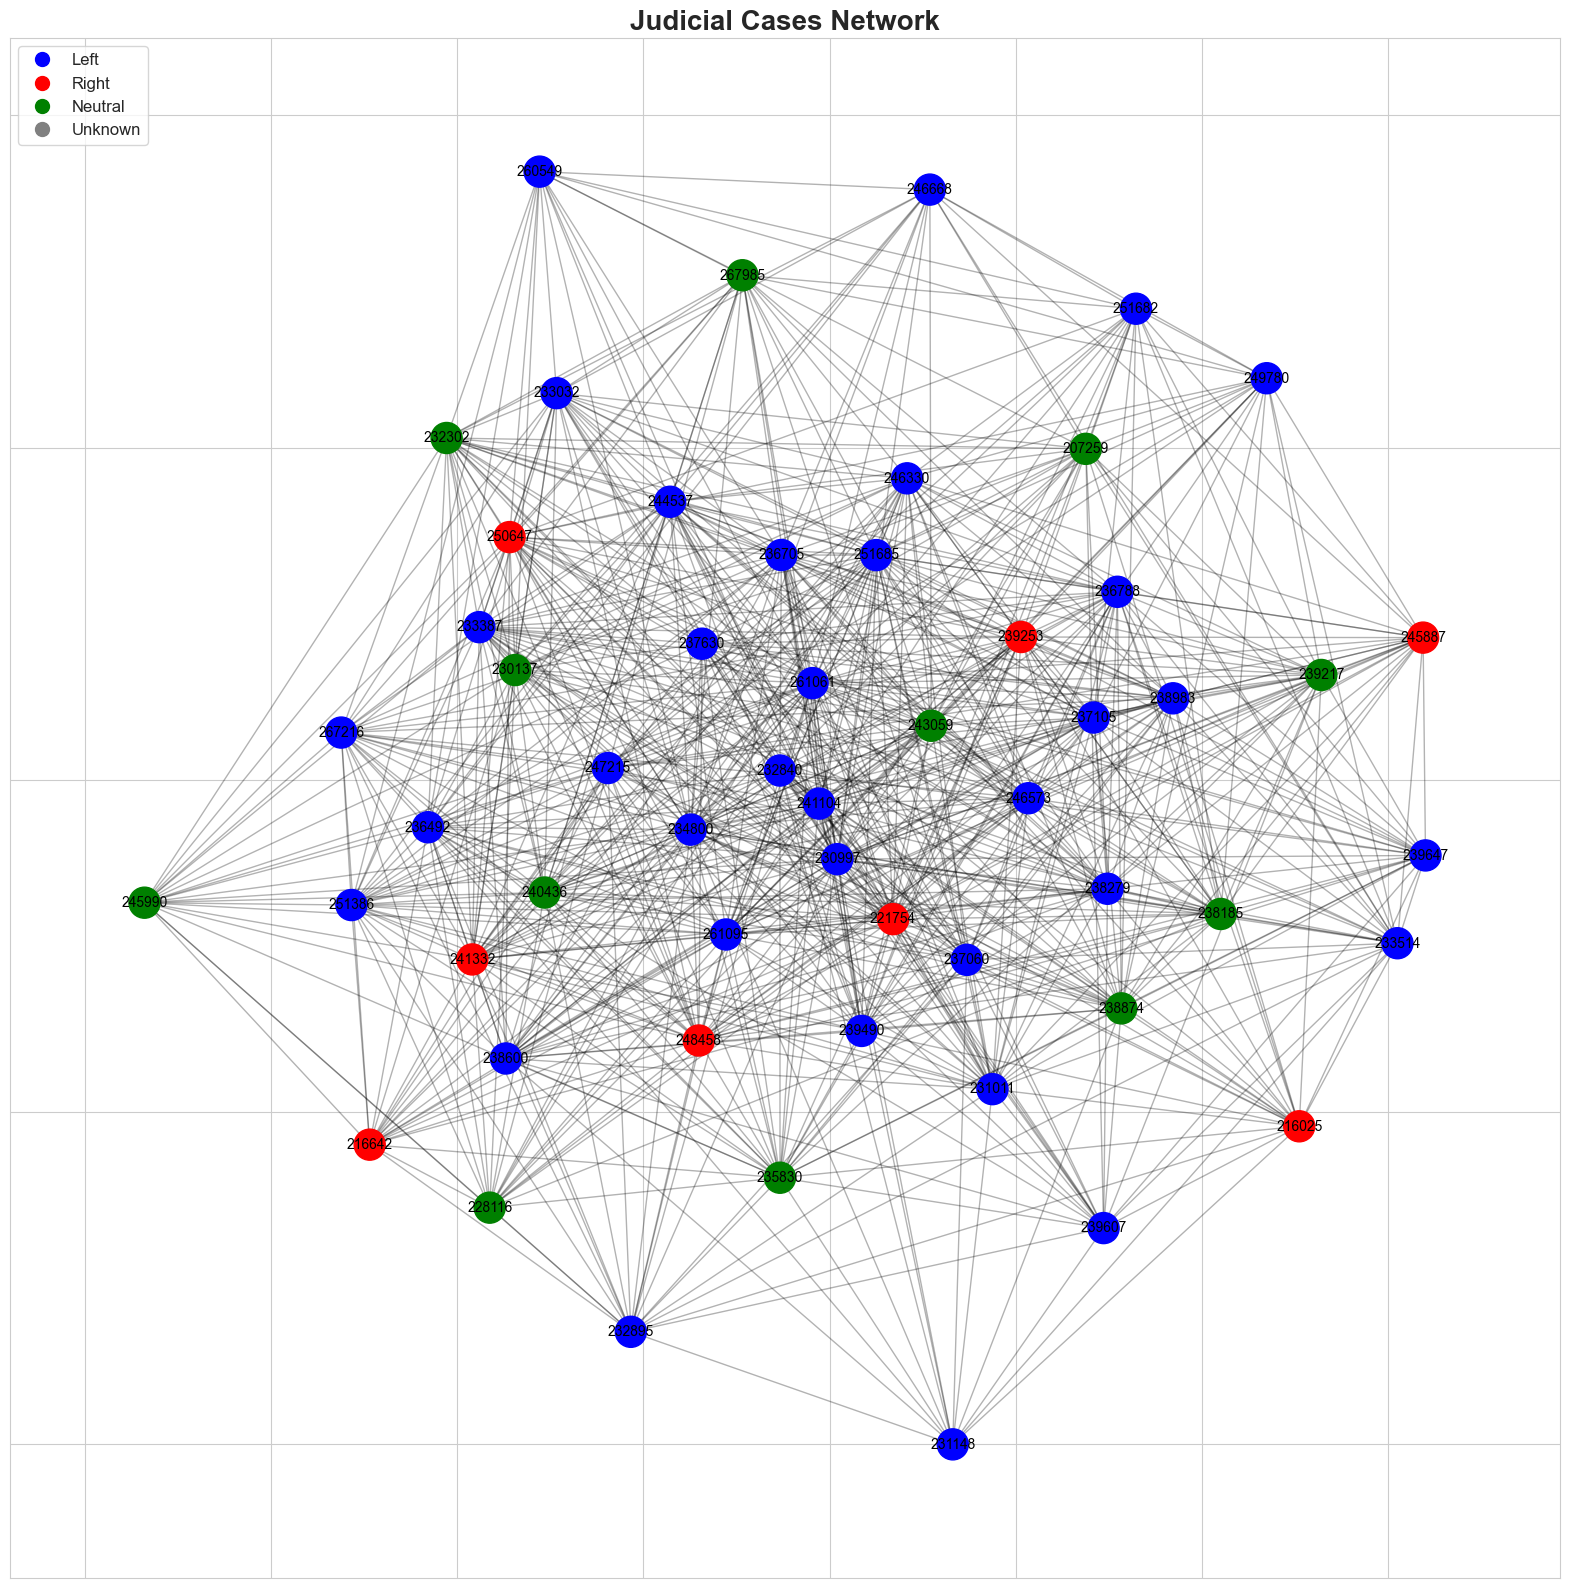

In [184]:
import matplotlib.lines as mlines

# Step 2: Create the graph
G = nx.Graph()

# Add nodes with attributes
for _, row in df.iterrows():
    G.add_node(
        row["CaseID"],
        political_view=row["PoliticalView"],
        judges=row["JudgeList"]
    )

# Add edges based on shared judges, avoiding self-loops
for i, case1 in df.iterrows():
    for j, case2 in df.iterrows():
        if case1["CaseID"] != case2["CaseID"]:  # Avoid self-loops
            # Check for shared judges
            if set(case1["JudgeList"]).intersection(case2["JudgeList"]):
                G.add_edge(case1["CaseID"], case2["CaseID"])

# Prepare color mapping for nodes
color_map = {
    "Left": "blue",
    "Right": "red",
    "Neutral": "green",
    "Unknown": "gray",
}
node_colors = [color_map[G.nodes[node]["political_view"]] for node in G.nodes]

# Get positions for nodes using spring layout
pos = nx.spring_layout(G, seed=42, k=0.3)  # Seed for reproducibility, k adjusts spacing

# Plot the graph
plt.figure(figsize=(20, 20))

# Draw edges with transparency (alpha)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="black")

# Draw nodes
nx.draw_networkx_nodes(
    G, pos, node_color=node_colors, node_size=500
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Add a legend for node colors
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10, label=label)
    for label, color in color_map.items()
]
plt.legend(handles=legend_handles, loc="upper left", fontsize=12)

# Add title
plt.title("Judicial Cases Network", fontsize=20, fontweight="bold")

# Show the plot
plt.show()


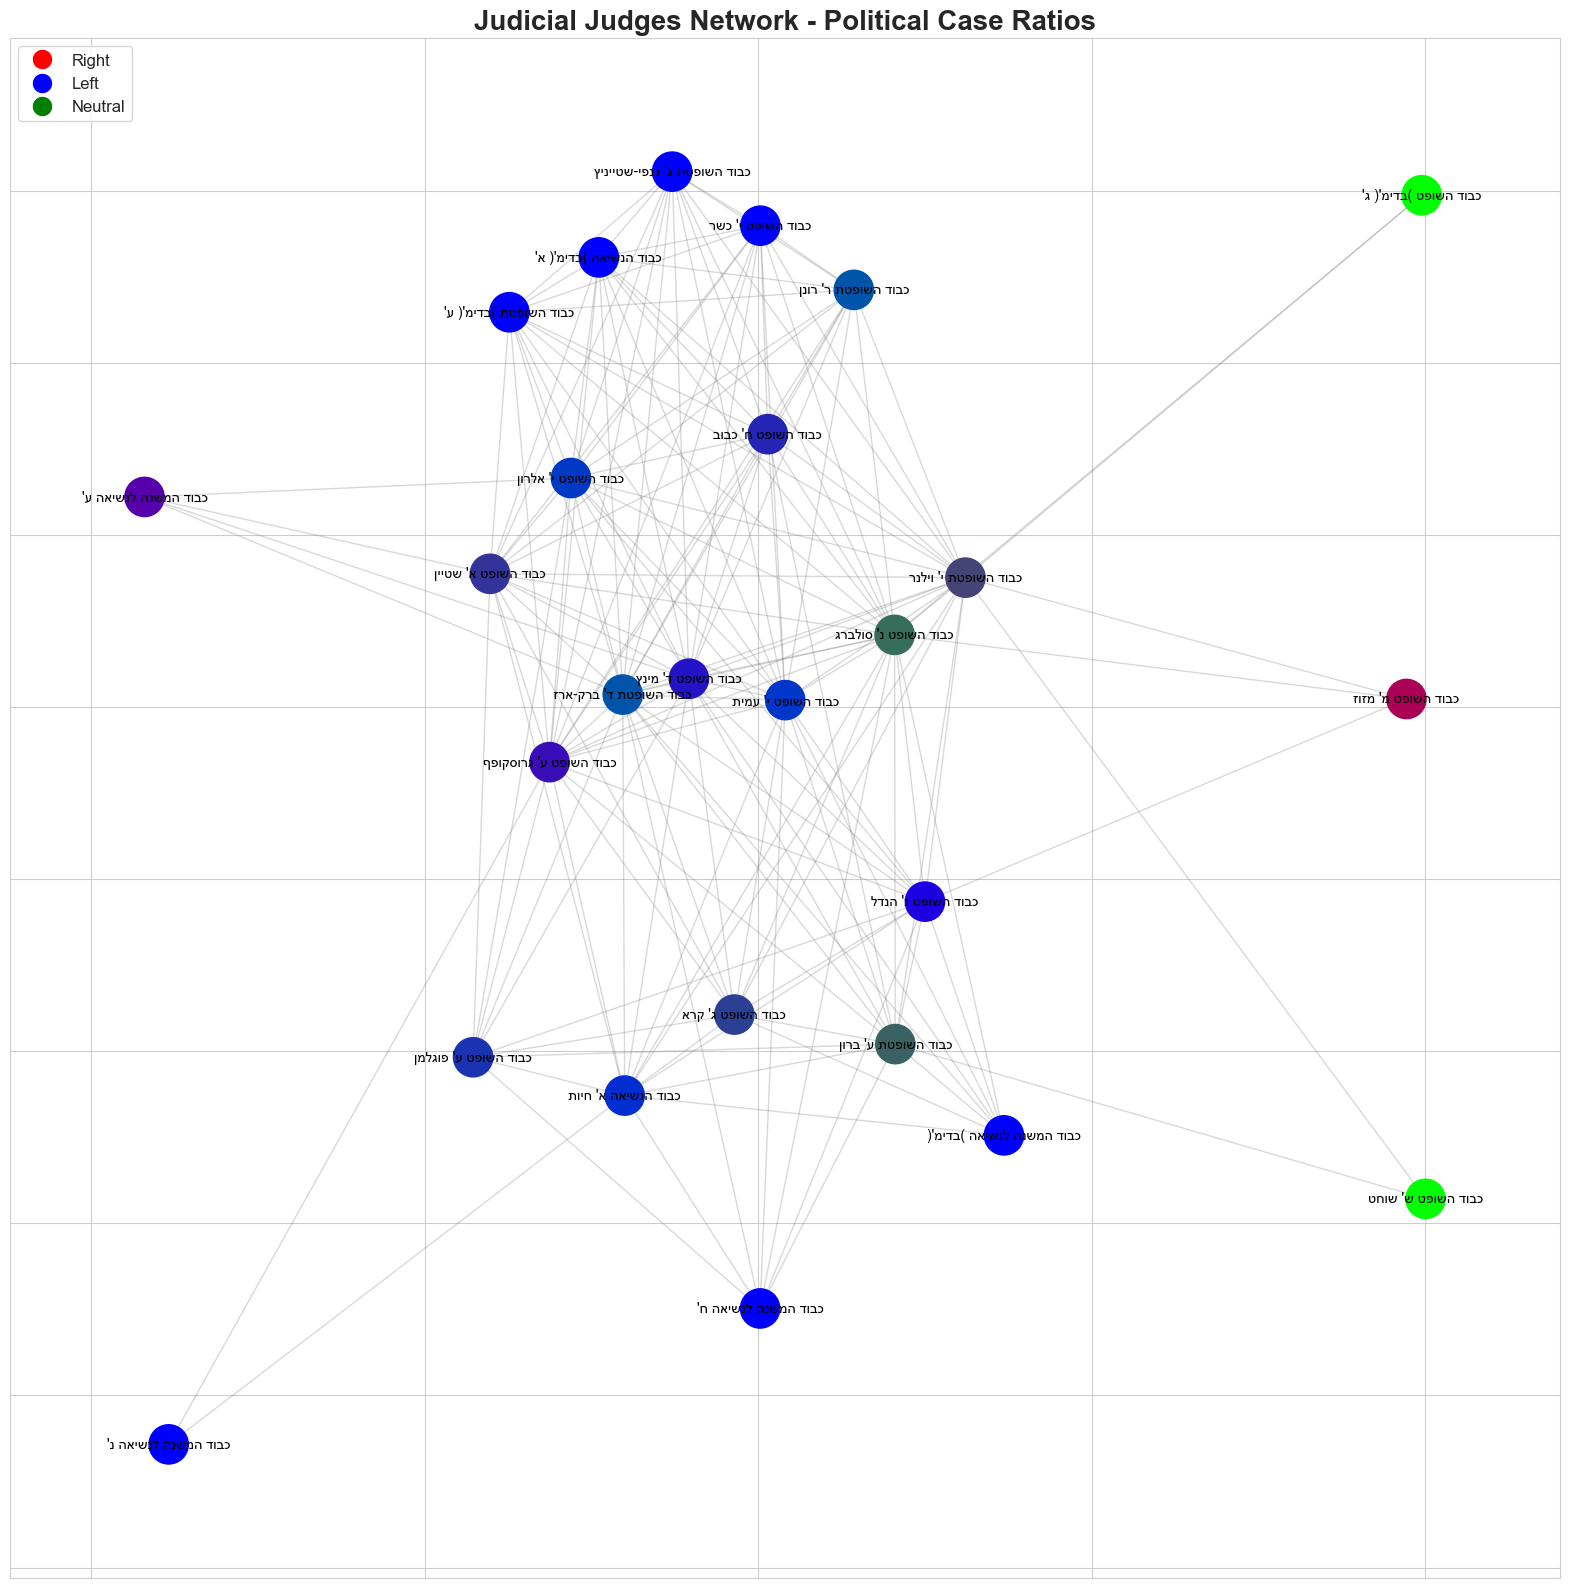

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd
from collections import defaultdict

# Step 1: Prepare data
judge_case_counts = defaultdict(lambda: {"Left": 0, "Right": 0, "Neutral": 0, "Unknown": 0})
case_judge_map = defaultdict(list)

# Iterate over the data
for _, row in df.iterrows():
    political_view = row["PoliticalView"]
    judges = row["JudgeList"]
    for judge in judges:
        judge_case_counts[judge][political_view] += 1
        case_judge_map[row["CaseID"]].append(judge)

# Normalize colors for each judge

# Set your OpenAI API key


judge_colors = {judge: calculate_color(counts) for judge, counts in judge_case_counts.items()}

# Step 2: Create the graph
G = nx.Graph()

# Add nodes with attributes
for judge, color in judge_colors.items():
    G.add_node(judge, color=color)

# Add edges based on shared cases
for case, judges in case_judge_map.items():
    for i, judge1 in enumerate(judges):
        for j, judge2 in enumerate(judges):
            if i < j and judge1 != judge2:  # Avoid self-loops and duplicates
                G.add_edge(judge1, judge2)

# Step 3: Visualize the graph
plt.figure(figsize=(20, 20))

# Draw edges with transparency
nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42, k=0.3), alpha=0.3, edge_color="gray")

# Draw nodes with proportional colors
node_colors = [G.nodes[node]["color"] for node in G.nodes]
nx.draw_networkx_nodes(
    G, pos=nx.spring_layout(G, seed=42, k=0.3), node_color=node_colors, node_size=800
)

# Draw labels
nx.draw_networkx_labels(G, pos=nx.spring_layout(G, seed=42, k=0.3), labels={node: node[::-1] for node in G.nodes}, font_size=10, font_color="black")

# Add title
plt.title("Judicial Judges Network - Political Case Ratios", fontsize=20, fontweight="bold")

# Add legend for color explanation
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, label='Right'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, label='Left'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Neutral'),
]
plt.legend(handles=legend_elements, loc="upper left", fontsize=12)

# Show plot
plt.show()
